# AE98 Electron Beam Shadowgraphy

## Notebook Objectives
The goal of this notebook is to mimic the analysis of Kasim et. al. (2017) to calculate the deflection angle of the electron beam in the AE98 experiment from e- shadowgraphy images.

## 1. Voronoi Tesselation and Lloyd's Algorithm

Voronoi and power diagrams are tesselations of 2D space around a certain number of key points or **sites**. Every point in the space is closest to one of the sites, and so we can divide space into sites and the collection of points those sites. Mathematically, the ith site has a **power cell** defined via

\begin{align}
|\vec{r}_0 - \vec{r}_{0i}|^2 -w_i \leq |\vec{r}_0 - \vec{r}_{0j}|^2 -w_j
\end{align}

for all other sites $j$, where $w_i, w_j$ are the weights of each cell.

In [1]:
import numpy as np
import random
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import tesselate as tess

%load_ext autoreload
%autoreload 2

# set plotting style
%matplotlib inline
plt.style.reload_library()
plt.style.use('ucla_presentations')

from ipywidgets import interact
import ipywidgets as widgets


Python packages like scipy have built in functions for Voronoi diagrams, but these do not allow us to use additive weights, which we'll need for the analysis later on. Best to write our own methods for calculating power diagrams so we can tweak and optimize from there.

### A Straightforward First Pass

The most intuitive way to make power diagrams that will be applied to pixellated data is to directly calculate them using numpy arrays (matrices). Then we can take advantage of numpy functions to keep things running quickly. 

This approach works, but it scales with the size of your data and gets very slow when we start using large datasets and many sites. I've kept this all here for posterity and because it demonstrates the mechanics of power diagrams and lloyd relaxation more clearly, but the more mathematically sophisticated approach I'll use later is significantly faster.

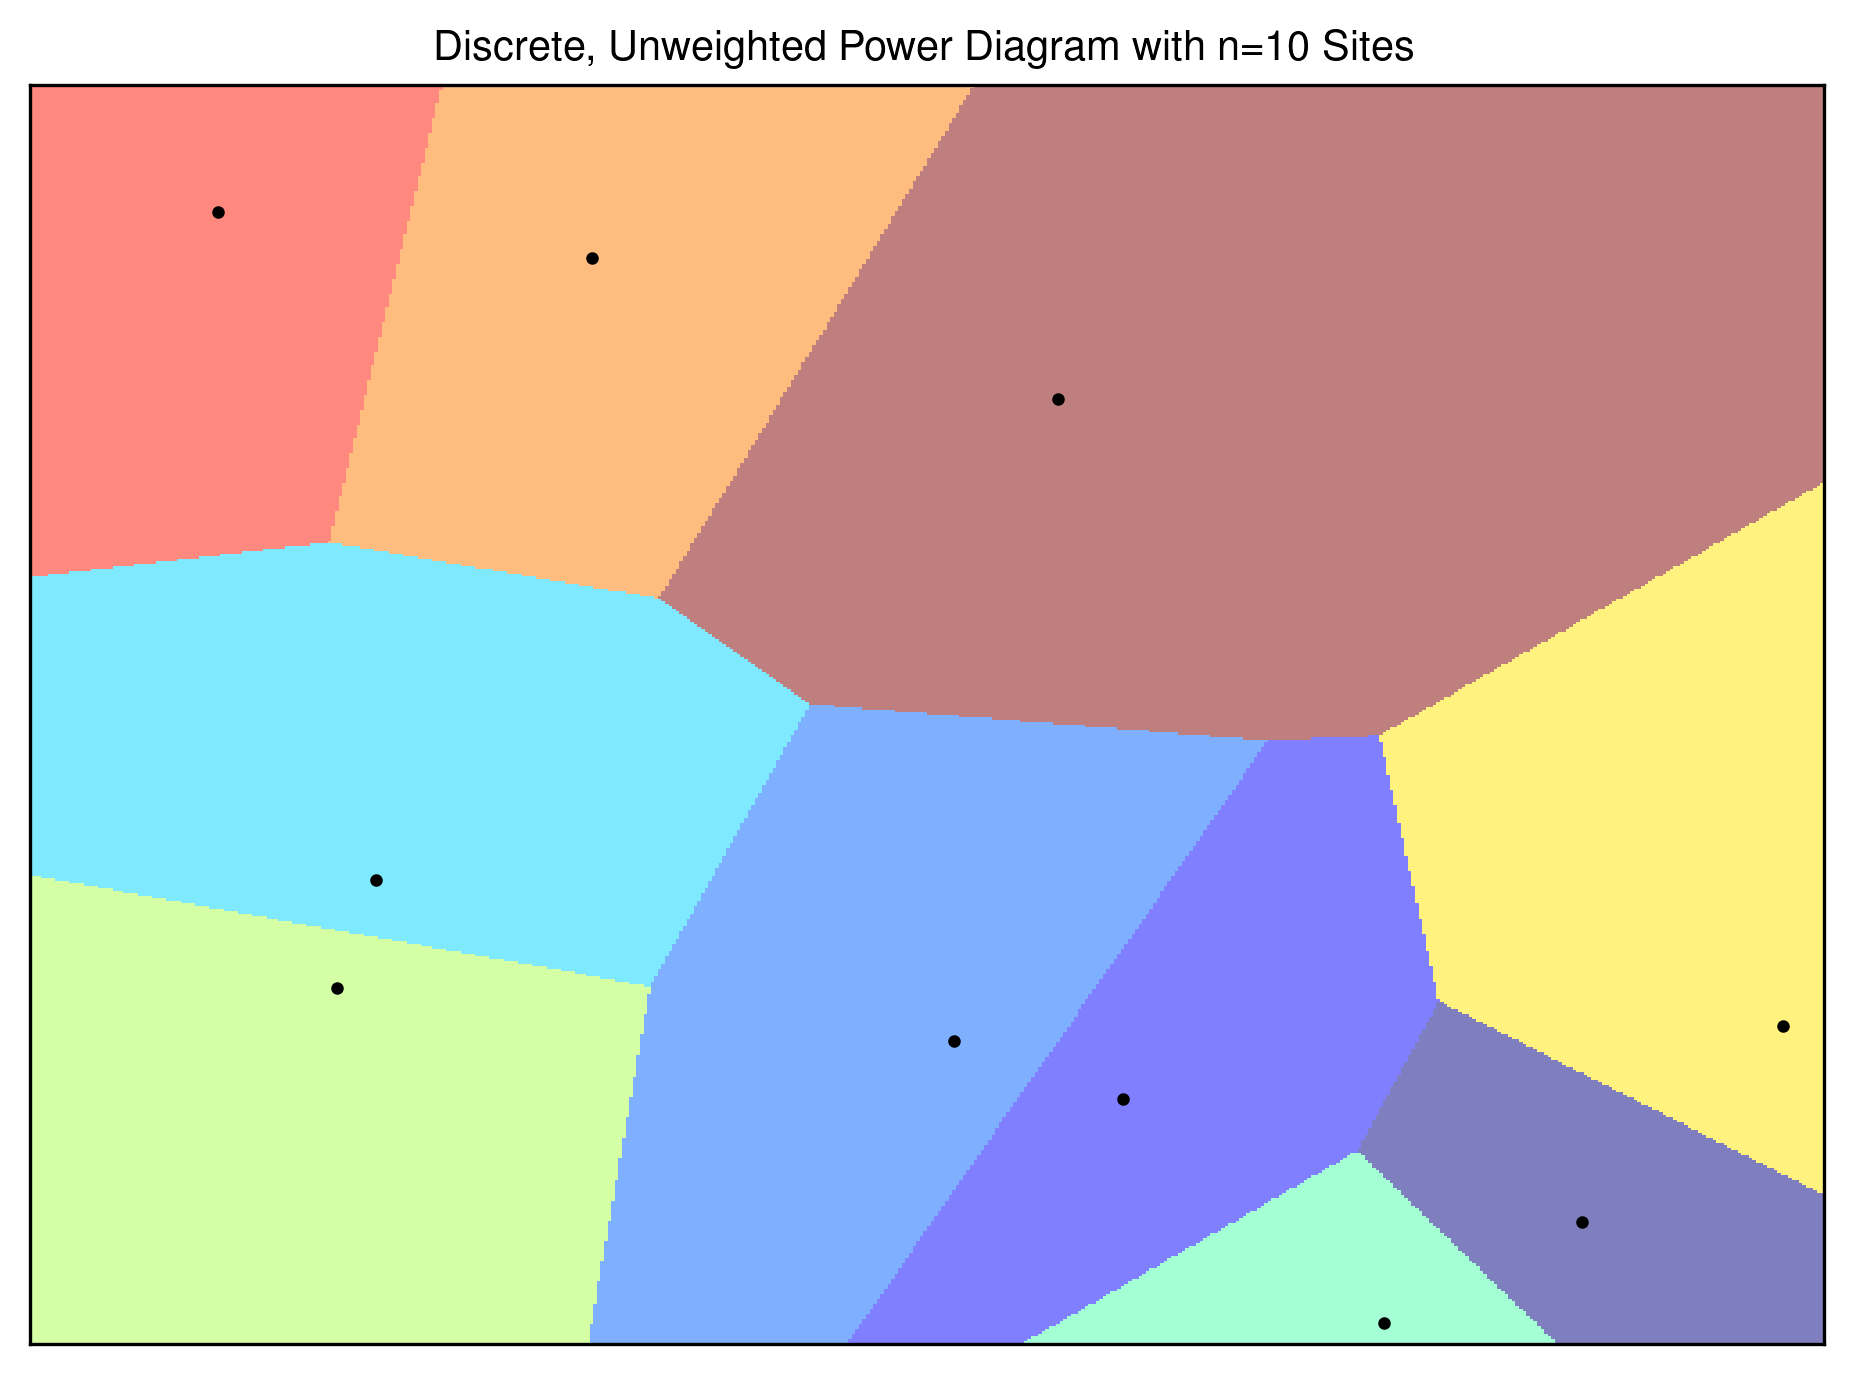

CPU times: user 811 ms, sys: 1.43 s, total: 2.24 s
Wall time: 847 ms


In [2]:
%%time
def voronoi_grid(points, shape, weights = 0):
    """
    Generate an array of size (shape, len(points)) that contains the
    indices of each pixel's voronoi cell
    """
    
    # Create arrays of indices with the right shape
    y, x = np.indices(shape)
    y_0, x_0 = points[:,0], points[:,1]
        
    # Calculate the distance from each point to each center
    d2 = (x[:,:,np.newaxis] - x_0[np.newaxis, np.newaxis,:])**2 +\
         (y[:,:,np.newaxis] - y_0[np.newaxis, np.newaxis,:])**2 - weights
    
    #print(f"distances = \n{d2}")

    # Find the index of the nearest center to each point
    nearest_center = np.argmin(d2, axis=2)
    
    #print(f"nearest center = \n{nearest_center}")

    return nearest_center

n=10
h, w = 500, 500
random_y, random_x = np.random.randint(h, size=n), np.random.randint(w, size=n)
points = np.array([random_y, random_x]).T

Y, X = np.indices((h,w))

grid = voronoi_grid(points, (h, w) )

fig, ax = plt.subplots()

ax.pcolormesh(X,Y, grid, cmap='jet', alpha=.5)
ax.plot(random_x, random_y,'ok')
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.set_title(f"Discrete, Unweighted Power Diagram with n={n} Sites")
plt.show()


### Lloyd's Algorithm

Lloyd's algorithm is an iterative method for dividing a space into cells of approximately equal area. The method proceeds like this:

1. Distribute a certain number of sites randomly on the plane
2. Construct the Voronoi diagram for those sites
3. Calculate the centroid of each cell
4. Move each site to the centroid of its cell
5. Repeat from step 2 until a stop condition is met.

Here's a quick demonstration of just one iteration of Lloyd's algorithm so you can see the way this works:

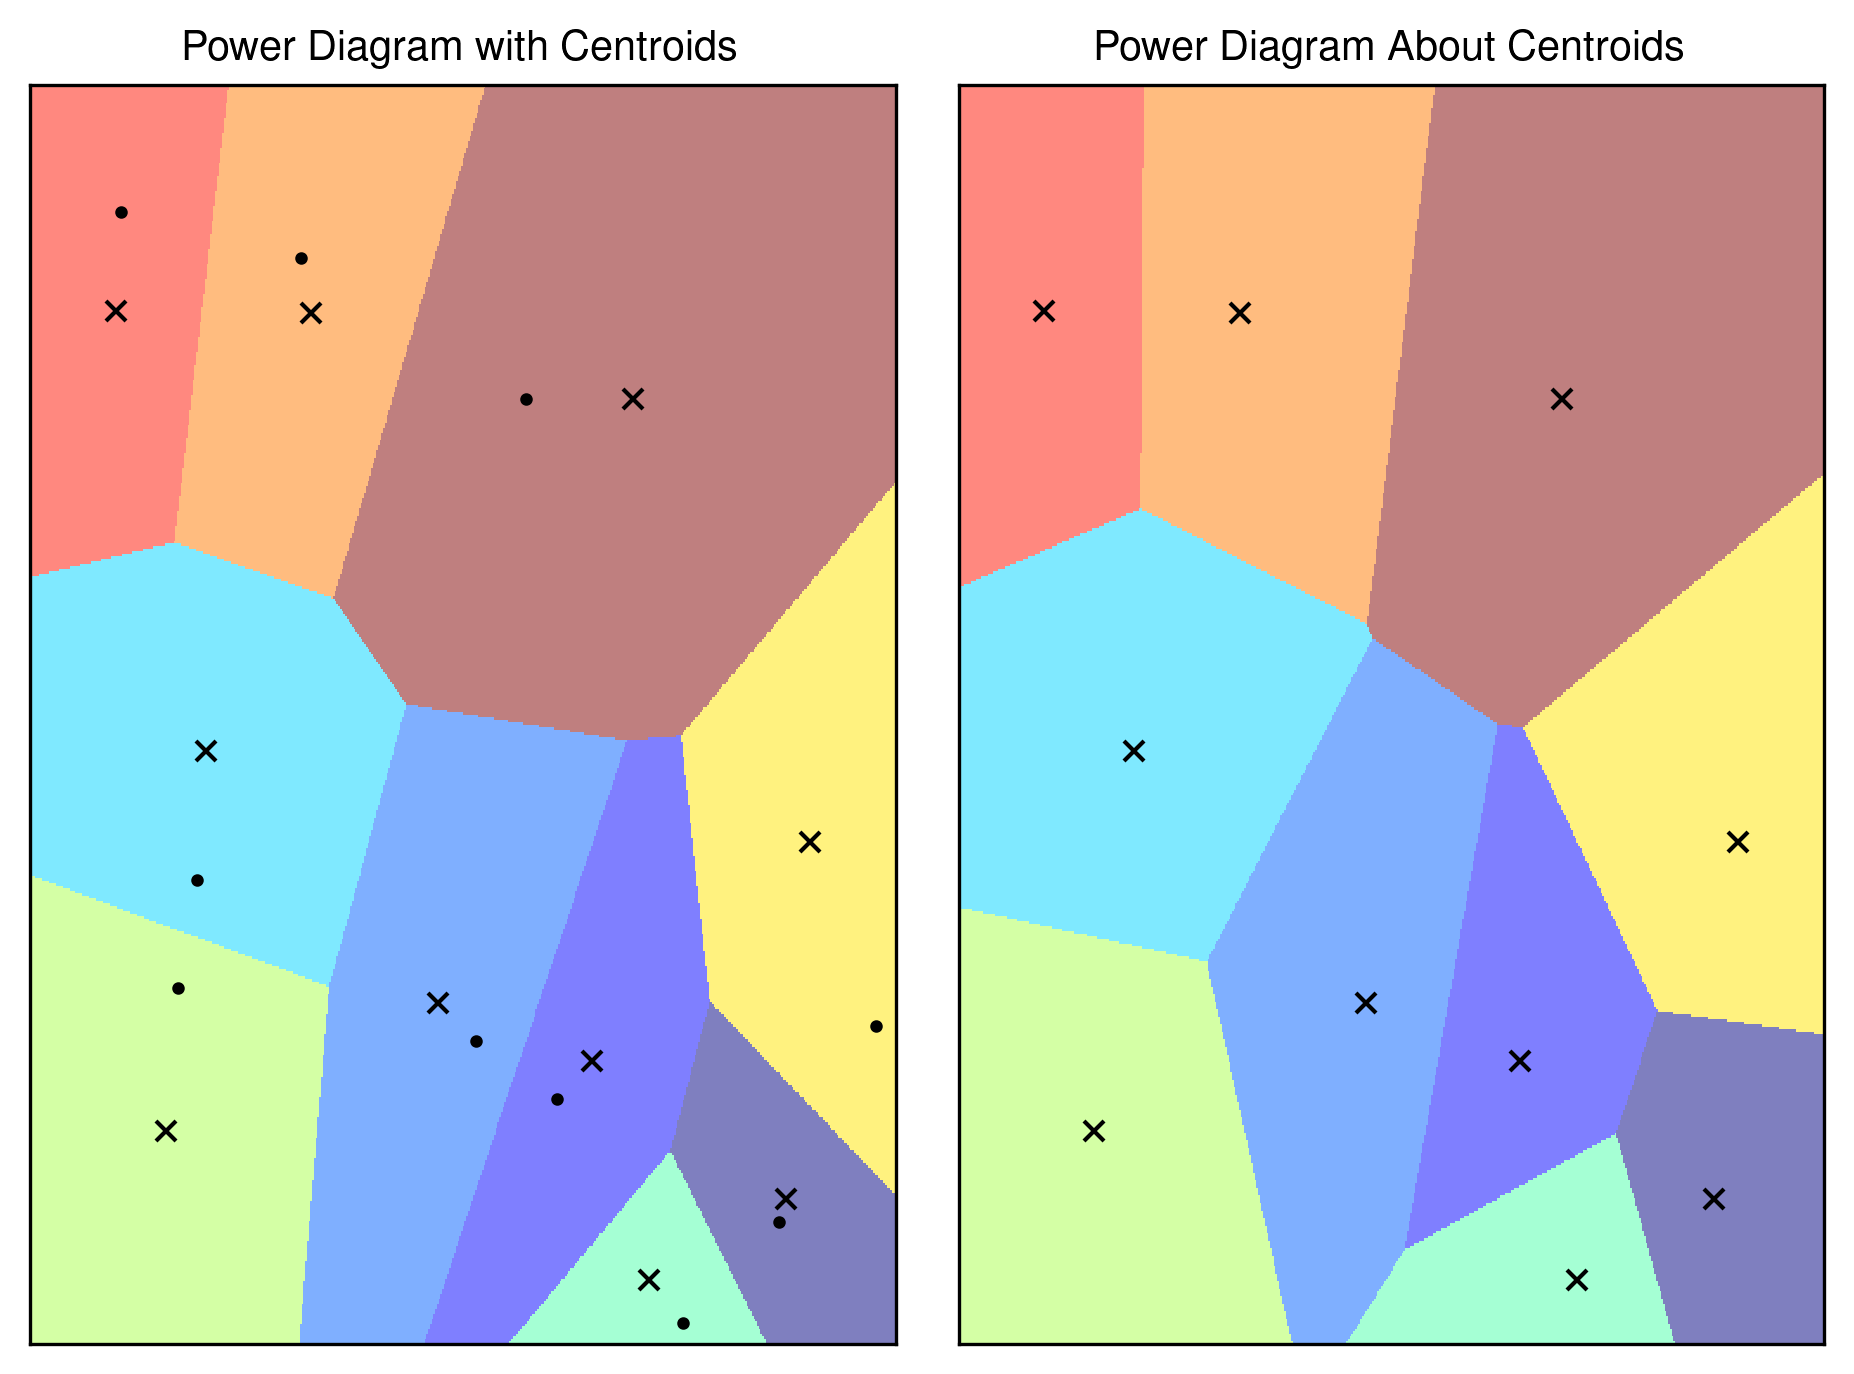

CPU times: user 786 ms, sys: 205 ms, total: 991 ms
Wall time: 766 ms


In [3]:
%%time
def find_centroids(n, grid):
    """
    Takes a 2D array of voronoi cell indices and calculates the centroid position of each cell
    """
    centroids = np.zeros((n,2), dtype=int)
    
    # Loop over the number of cells

    for i in range(n):
        # First we need to get all the points in a region
        points = np.argwhere(grid == i)
        # Get the number of points in the centroid
        num = points.shape[0]
        #print(f"for i = {i} found {num} points in cell:\n\tx = {points[:,1]}, y = {points[:,0]}")
        centroids[i] = np.rint( np.sum(points, axis=0) / num)
        #print(f"\tFound centroid = ({centroids[i,1]},{centroids[i,0]})")
    
    return centroids


centroids = find_centroids(n, grid)

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.pcolormesh(X,Y, grid, cmap='jet', alpha=.5)
ax1.plot(random_x, random_y,'ok', label='Sites')
ax1.plot(centroids[:,1], centroids[:,0],'kx', markersize=5, label='Centroids')
ax1.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax1.set_title(f"Power Diagram with Centroids")
#ax1.legend()
    
grid_c = voronoi_grid(centroids, (h, w) )

ax2.pcolormesh(X,Y, grid_c, cmap='jet', alpha=.5)
ax2.plot(centroids[:,1], centroids[:,0],'kx', markersize=5, label='Centroids')
ax2.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax2.set_title(f"Power Diagram About Centroids")
plt.show()

Centroids no longer changing at i=28 iterations


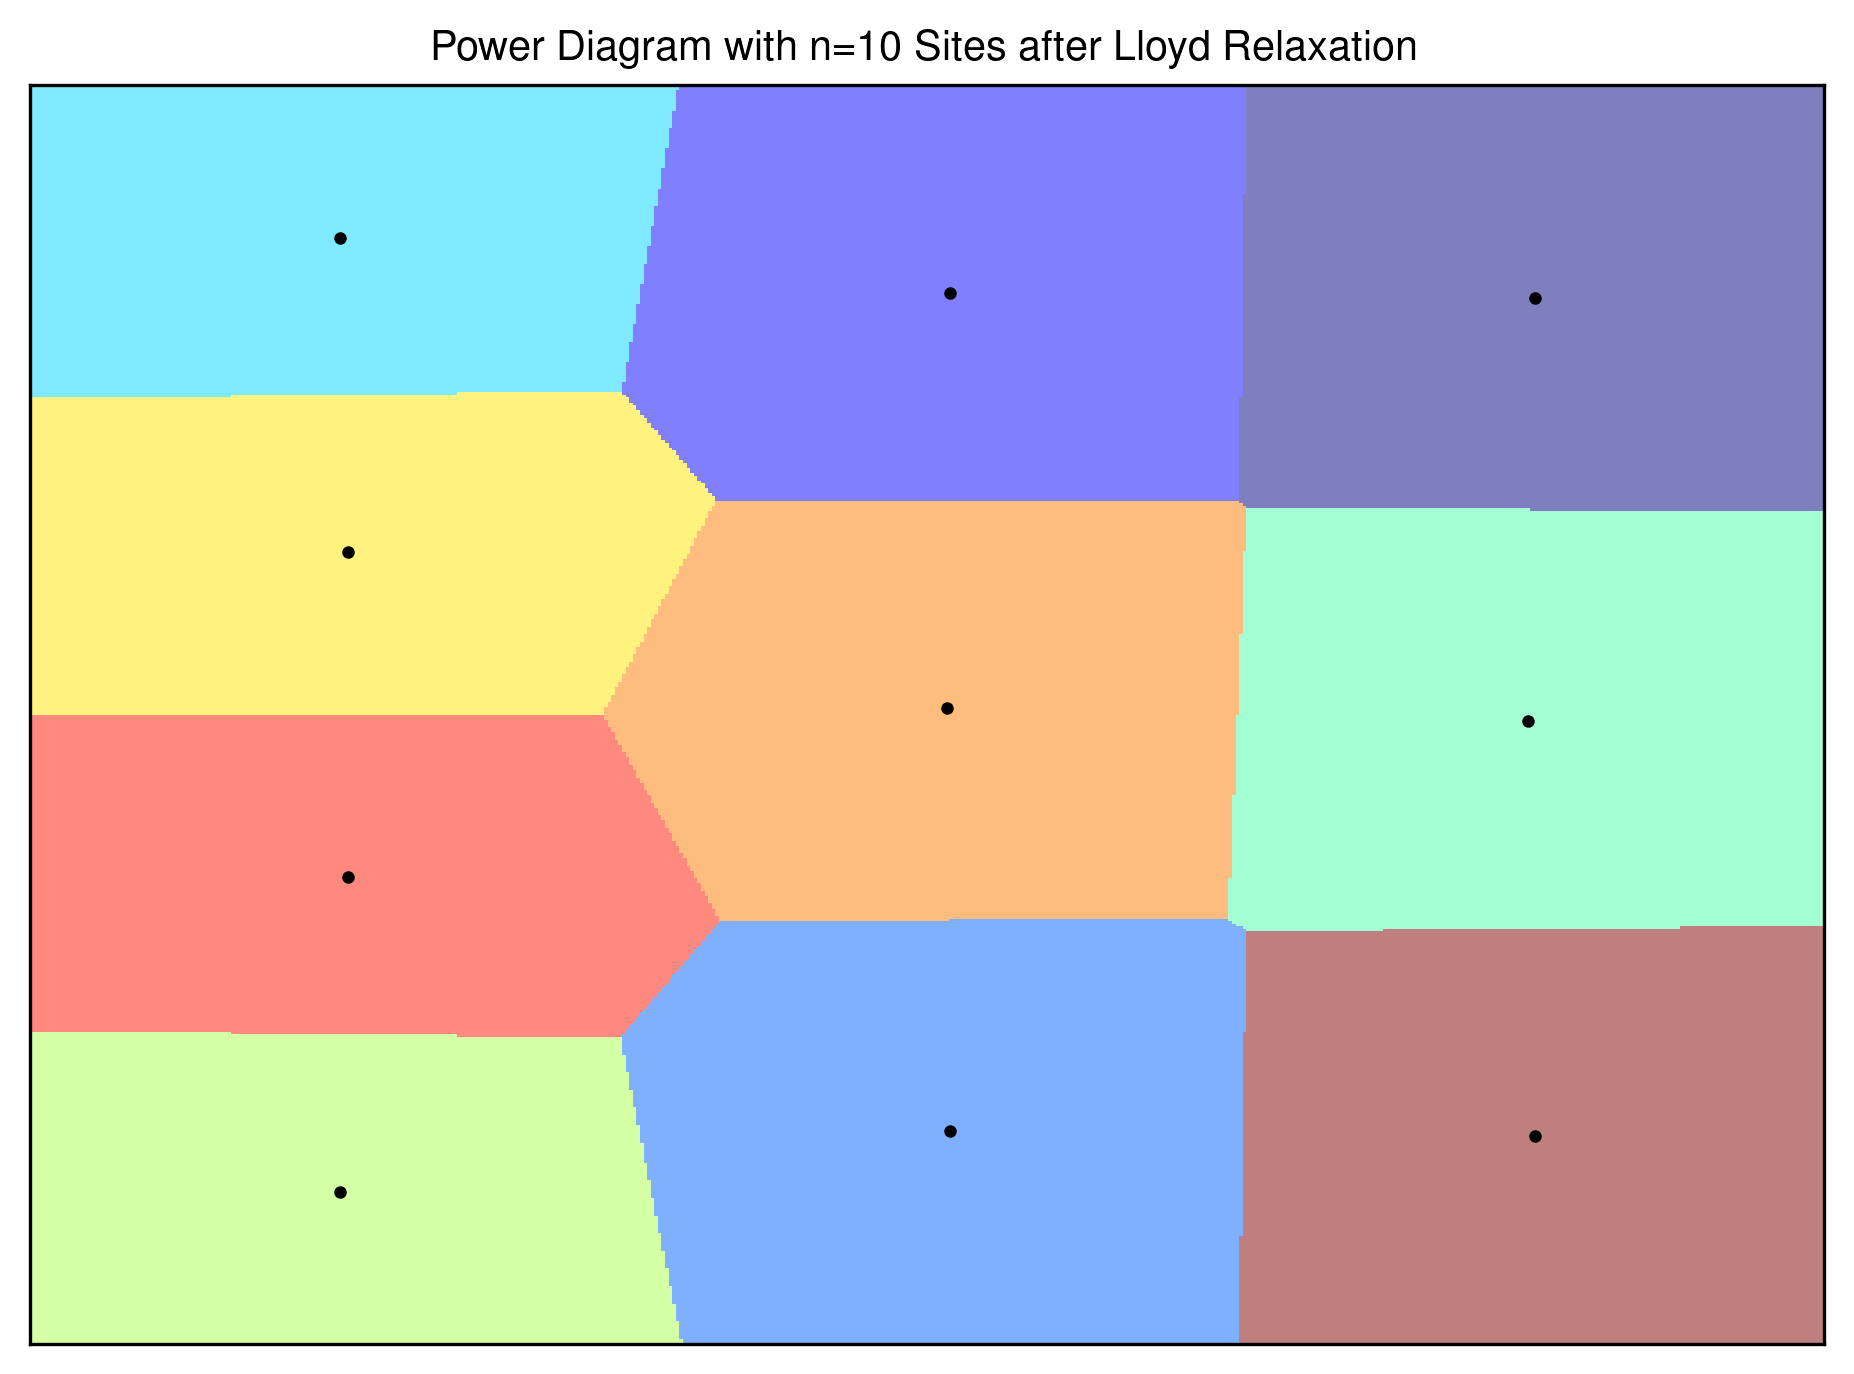

CPU times: user 1.55 s, sys: 455 ms, total: 2.01 s
Wall time: 1.78 s


In [4]:
%%time
def lloyd_distribute(n, shape, allowance = 0.1, MAXDEPTH = 1000):
    """
    Throw n sites onto a grid with shape, and use lloyd's algorithm to distribute them evenly
    within an allowance of the perfectly split area in each cell
    """
    
    ideal_volume = (shape[0] * shape[1]) / n
    threshold = ideal_volume * allowance
    Y, X = np.indices(shape)

    h, w = shape
    
    # Generate n random sites to start with
    random_y, random_x = np.random.randint(h, size=n), np.random.randint(w, size=n)
    random_points = np.array([random_y, random_x]).T

    grid = voronoi_grid(random_points, shape)
    

    centroids = find_centroids(n, grid)
    for i in range(MAXDEPTH):

        grid = voronoi_grid(centroids, shape)
        old_centroids = np.copy(centroids)
        centroids = find_centroids(n, grid)
        if np.array_equal(centroids,old_centroids):
            print(f"Centroids no longer changing at i={i+1} iterations")
            break
    
    return grid, centroids

lgrid, lpoints = lloyd_distribute(n, (h,w))

lgrid_offset = np.roll(np.roll(lgrid+1, 1, axis=0), 1, axis=1)-(lgrid+1)
y_edges, x_edges = np.nonzero(lgrid_offset)
#print(f"edges = {edges}")

grad_y, grad_x = np.gradient(lgrid)
edges = grad_x**2 + grad_y**2
y_edges, x_edges = np.nonzero(edges)
fig, ax = plt.subplots()

ax.pcolormesh(X,Y, lgrid, cmap='jet', alpha=.5)
#ax.pcolormesh(X,Y, edges, cmap='jet', alpha=1)
#ax.plot(x_edges, y_edges, 'k.', alpha=1)
ax.plot(lpoints[:,1], lpoints[:,0],'ok')
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.set_title(f"Power Diagram with n={n} Sites after Lloyd Relaxation")
plt.show()



### Deeper Down the Geometry Hole

Scipy doesn't have a built-in way to calculate weighted Voronoi diagrams, so we can't *easily* take advantage of the more sophisticated algorithms written in C++ for this analysis. However, a fun property of Voronoi diagrams can help us out here. 

**A 2D Voronoi diagram is equivalent to the intersection of half-planes given by the projection of each site onto a 3D paraboloid.**

We can manipulate this paraboloid to give the weighting we want while still taking advantage of scipy's speedy C++ integrations using convex hull algorithms.

#### Delaunay Triangulation

The **dual** of a Voronoi diagram is the **Delaunay Triangulation**, shown in green here:

<p style="text-align:center;"><img src="voronoi_delaunay.png" alt="voronoi and delaulay diagrams" width="300"></p>

The Delaunay triangulation is the projection of the convex hull of the sites when lifted onto a hyperboloid, so if we use a weighted hyperbola equation to lift the sites from 2D to 3D and calculate the convex hull, we then have the weighted Delaunay triangulation on the 2D plane. Once we have these triangles, we can get the Voronoi or Power diagram from there.

This diagram from Hang Si's lecture notes demonstrates this projection onto the hyperbola:

<p style="text-align:center;"><img src="delaunay_projection.png" alt="delaulay diagram from 3D projection" width="500"></p>

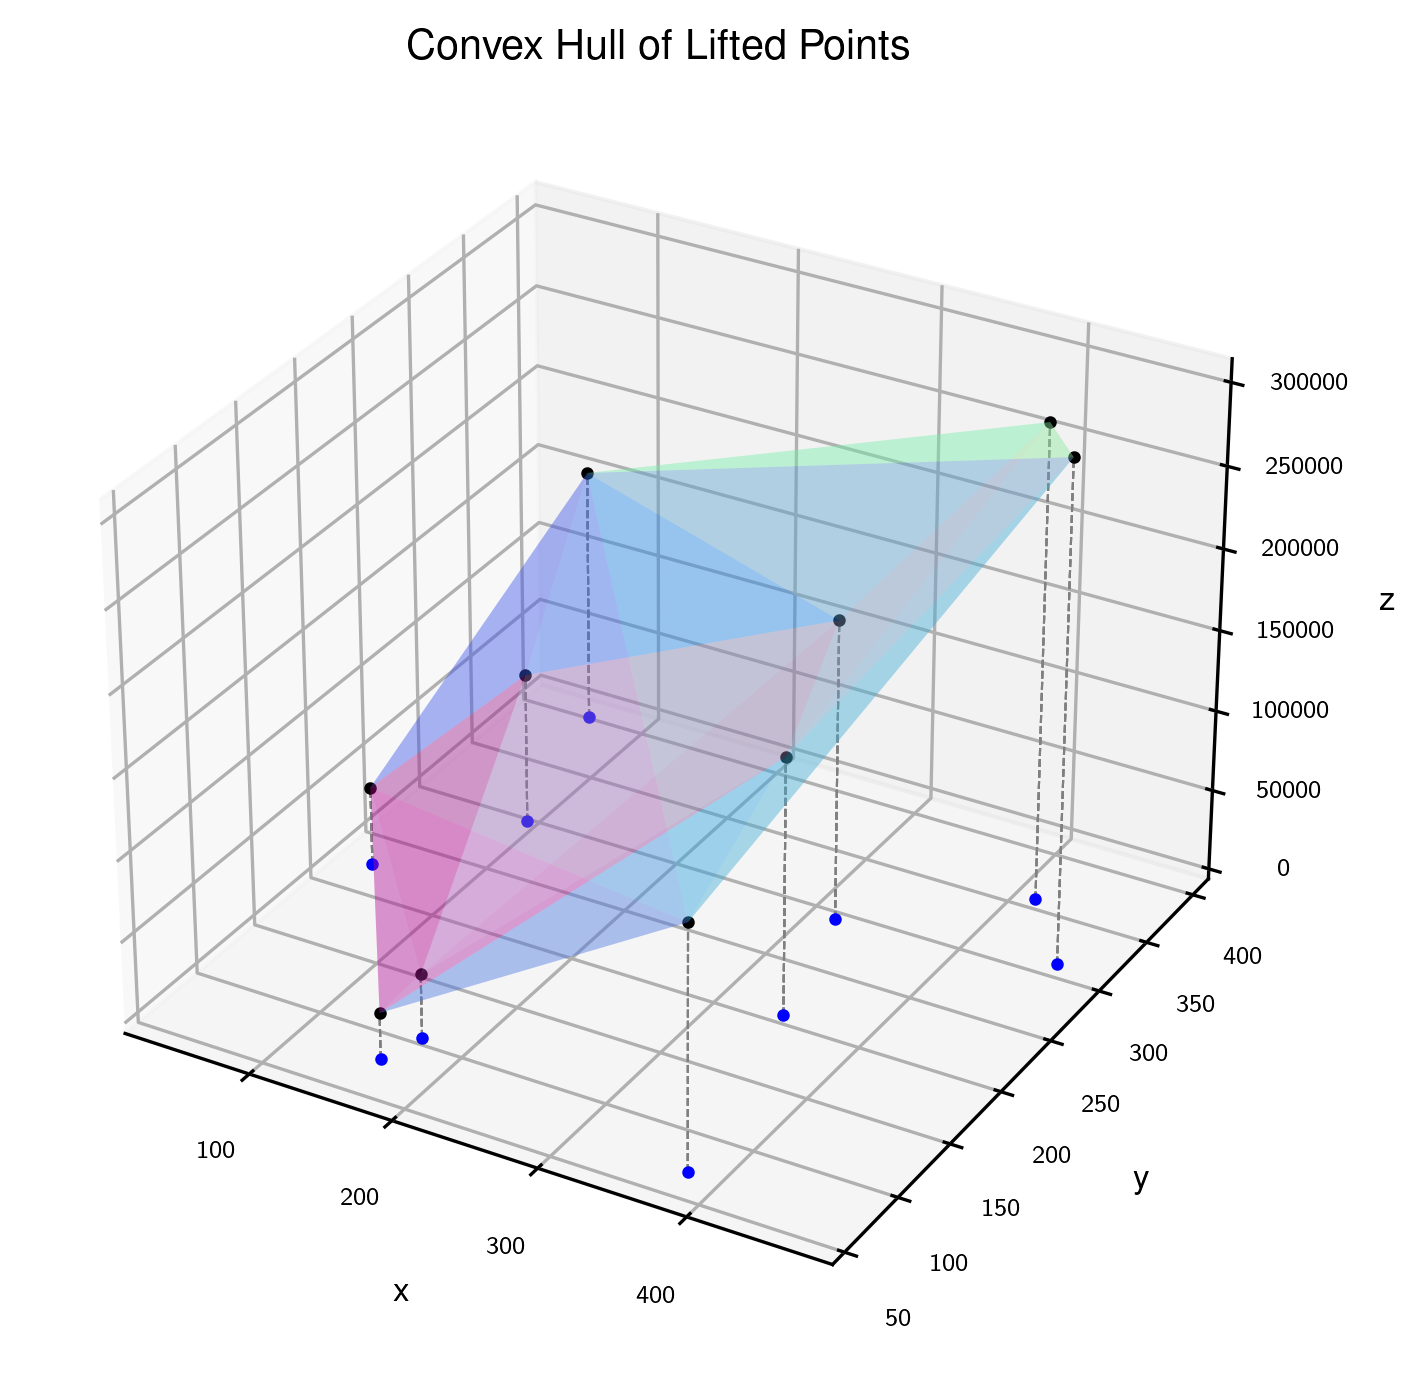

In [124]:
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib as mpl


# First we need to lift  our 2D points onto a weighted hyperbola
def lift_points(points, weights):
    """
    Lift 2D points onto 3D paraboloid for calculating weighted 
    Delaunay triangulations and Voronoi diagrams
    
    Arguments:
        points: 2D numpy array of point coordinates with shape (N, 2)
        weights: 1D numpy array of length N holding each points corresponding weight
        
    Returns:
        3D numpy array of coordinates with shape (N, 3) where the third column is 
        the z projection
    """
    z = np.sum(points * points, axis=1) - weights
    return np.hstack((points, z[np.newaxis,:].T))
    
# Demonstrating the data structure real quick
n=10
h, w = 500, 500
random_y, random_x = np.random.randint(h, size=n), np.random.randint(w, size=n)
points_xy = np.array([random_y, random_x]).T
#print(f"2D Points = \n{points_xy}")
weights = np.array([1,1,5,1,1,10,1,3,8,1])*500
#weights = np.zeros(n)
points_xyz = lift_points(points_xy, weights)
#print(f"Projection to 3D = \n{points_xyz}")

# Plot the 3D convex hull
fig = plt.figure()
ax = plt.axes(projection='3d')

hull = ConvexHull(points_xyz)

colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,len(hull.simplices)))
for i, s in enumerate(hull.simplices):
    for j in s:
        x, y = [points_xyz[j,0],points_xyz[j,0]],[points_xyz[j,1],points_xyz[j,1]]
        ax.plot(x, y, [0,points_xyz[j, 2]], '--', color='grey', lw=0.5)
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot_trisurf(points_xyz[s, 0], points_xyz[s, 1], points_xyz[s, 2], color=colors[i], alpha=.25)

ax.plot(points_xyz[:, 0], points_xyz[:, 1], points_xyz[:, 2], 'ko')
ax.plot(points_xyz[:, 0], points_xyz[:, 1], 0, 'bo')
    
# Make axis labels
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.set_title('Convex Hull of Lifted Points')
plt.show()

The convex hull objects returned by scipy have the property <code>equations</code>, which is an array containing the normal vector $V$ and offset $b$ of each face of the hull, such that for any point $\vec{x}$ inside the convex hull,  $\vec{V}\cdot \vec{x} + b < 0$.

This means that any *lower-facing* faces of the hull will have normal vectors with negative z-components.

Normal vectors of faces, (Vx, Vy, Vz, b): 
[[-6.77386788e-01 -7.35626133e-01  1.15386055e-03  1.32522194e+02]
 [-7.06988222e-01 -7.07224131e-01  1.29686538e-03  1.20596898e+02]
 [-7.05309928e-01 -7.08897600e-01  1.44857436e-03  9.72792228e+01]
 [-1.16310281e-03  9.99998024e-01 -1.61239013e-03 -1.39285429e+02]
 [ 4.89912778e-01  8.71770694e-01 -1.15212287e-03 -1.93705438e+02]
 [ 9.39881774e-01  3.41495983e-01 -1.65684736e-03 -1.32700080e+02]
 [ 9.53984242e-01  2.99855224e-01 -9.54351118e-04 -2.40963389e+02]
 [-9.81092941e-01 -1.93521167e-01  2.48979344e-03 -2.50851004e+02]
 [ 4.71476526e-01  8.81878104e-01 -9.46628180e-04 -2.28786200e+02]
 [ 8.54652311e-01  5.19199737e-01 -1.03030599e-03 -2.37876721e+02]
 [ 8.18572129e-01  5.74402748e-01 -1.07361313e-03 -2.29388546e+02]
 [ 6.85856003e-01  7.27735442e-01 -1.63429045e-03 -1.26298660e+02]
 [ 7.03226932e-01  7.10963588e-01 -1.63042817e-03 -1.27829657e+02]
 [ 9.17934245e-01  3.96729004e-01 -1.67925672e-03 -1.32470871e+02]
 [ 5.75029331e-01  

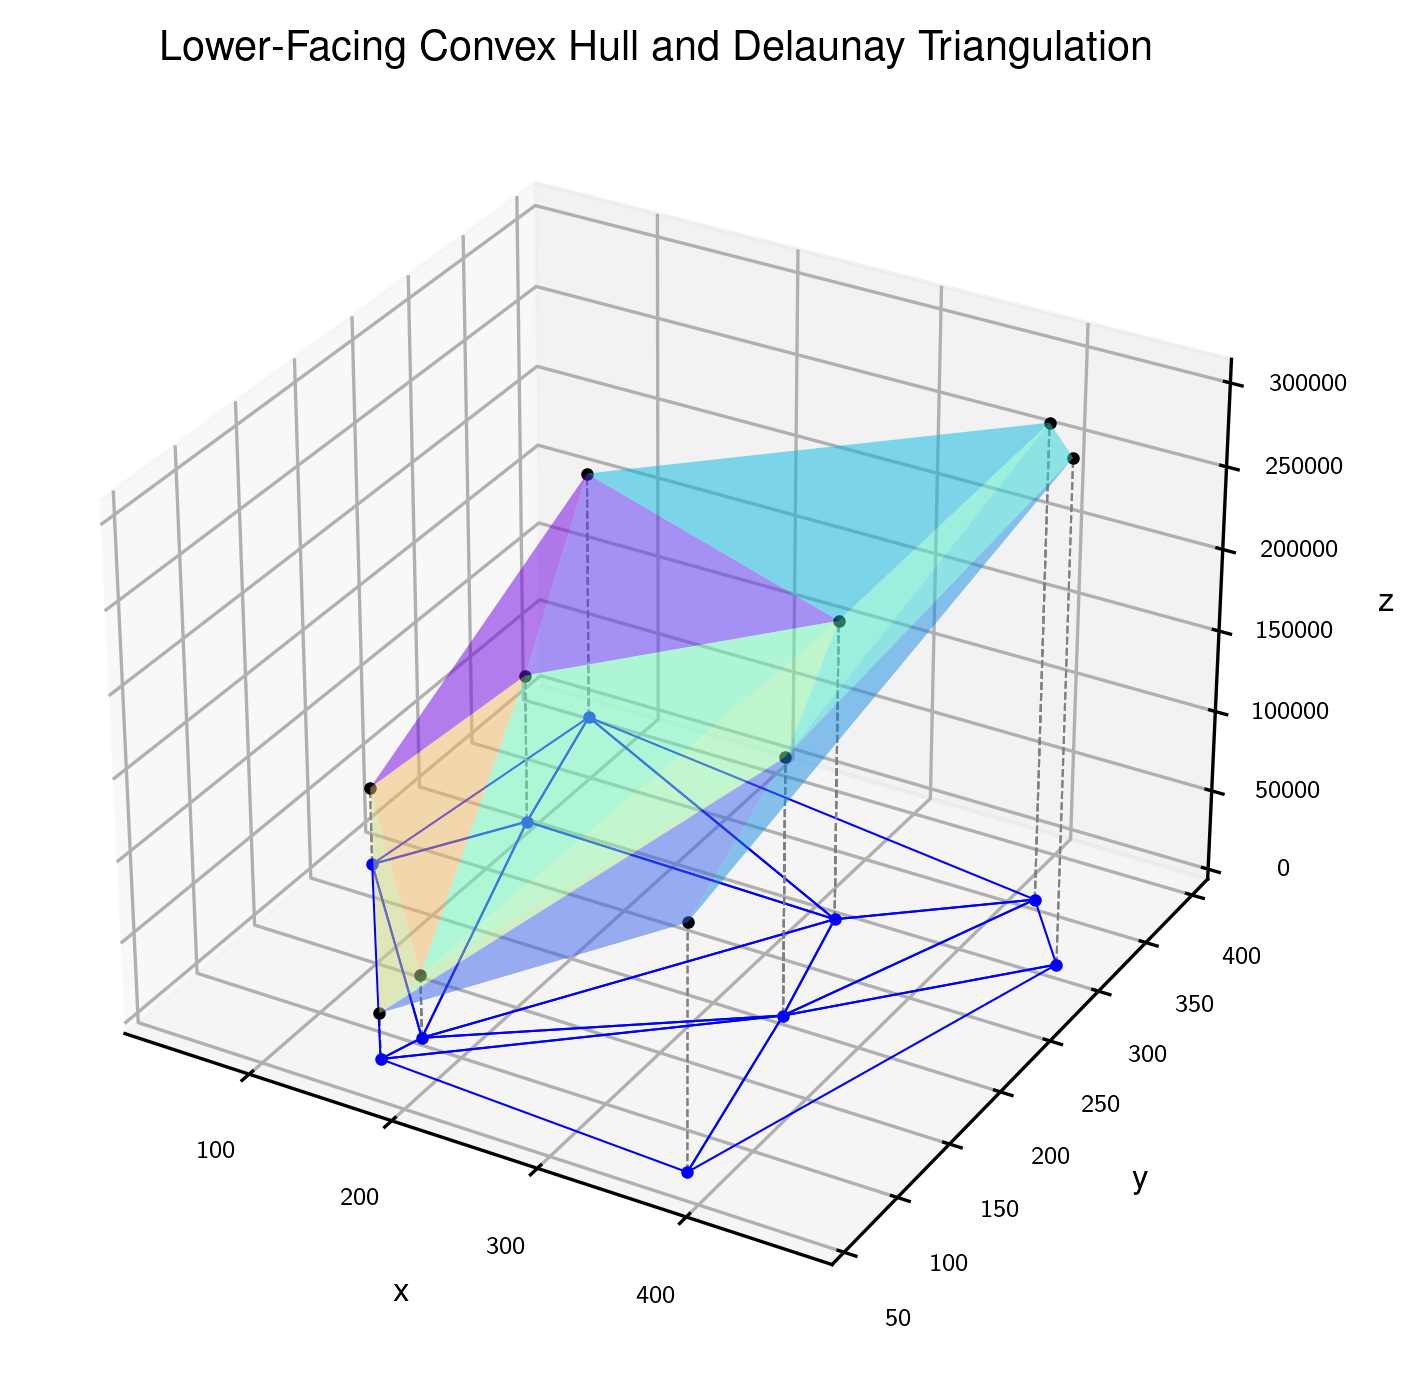

In [125]:
# Now we need to determine which faces of the convex hull are pointing down
def get_lower_facing(hull):
        return np.where(hull.equations[:,2] < 0)[0]
    
print(f"Normal vectors of faces, (Vx, Vy, Vz, b): \n{hull.equations}")

lowers = get_lower_facing(hull)
# Plot the 3D convex hull
fig = plt.figure()
ax = plt.axes(projection='3d')

for i, s in enumerate(hull.simplices[lowers]):
    for j in s:
        x, y = [points_xyz[j,0],points_xyz[j,0]],[points_xyz[j,1],points_xyz[j,1]]
        ax.plot(x, y, [0,points_xyz[j, 2]], '--', color='grey', lw=0.5)
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot_trisurf(points_xyz[s, 0], points_xyz[s, 1], points_xyz[s, 2], color=colors[i], alpha=.5)
    
    # Projecting these back to z=0 gives the Delaunay Triangulation
    ax.plot(points_xyz[s, 0], points_xyz[s, 1], 0, 'b-', lw=0.5)

ax.plot(points_xyz[:, 0], points_xyz[:, 1], points_xyz[:, 2], 'ko')
ax.plot(points_xyz[:, 0], points_xyz[:, 1], 0, 'bo')
    
# Make axis labels
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))
ax.set_title('Lower-Facing Convex Hull and Delaunay Triangulation')
plt.show()

#### Calculating the dual graph

Now we have a weighted Delaunay triangulation, and we need to find the dual of this plot to get the weighted Voronoi diagram.

The vertices of each Voronoi cell are defined by the **weighted circumcenters** of all the triangles surrounding the site.

The coordinates of the unweighted circumcenter are

\begin{align}
U_x &= \frac{1}{D}\big((A_x^2 + A_y^2)(B_y - C_y)+(B_x^2 + B_y^2)(C_y - A_y)+(C_x^2 + C_y^2)(A_y - B_y)\big) \\
U_y &= \frac{1}{D}\big((A_x^2 + A_y^2)(C_x - B_x)+(B_x^2 + B_y^2)(A_x - C_x)+(C_x^2 + C_y^2)(B_x - A_x)\big) \\
D &= 2\big(A_x(B_y - C_y) + B_x(C_y - A_y) + C_x(A_y - B_y)\big)
\end{align}

However to take into account the weights this point is offset by *half the local gradient of the linear function defined by the three weights of the vertices*. In other words if $\boldsymbol{c}_{ijk}^0$ is the unweighted circumcenter, the weighted circumcenter is
\begin{align}
\boldsymbol{c}_{ijk} = \boldsymbol{c}_{ijk}^0 - \frac{1}{2}\big(\nabla w\big)_{ijk}
\end{align}

In reality we've *already calculated* the weighted circumcenters, because we have the normal vectors $\vec{V} = (V_x, V_y, V_z)$ of each face of the 3D convex hull. Projecting these vectors back down to the $z=0$ plane gives the weighted circumcenter for one of our triangles:
\begin{align}
\vec{c} = -\frac{ \vec{V}_\perp}{2 V_z}
\end{align}

We can double check this weighting by returning to the definition of a power diagram: each edge of a cell is defined by the intersection of the circles centered at two neighboring sites, with radii given by $\sqrt{w_i}$.

Number of equations: 12


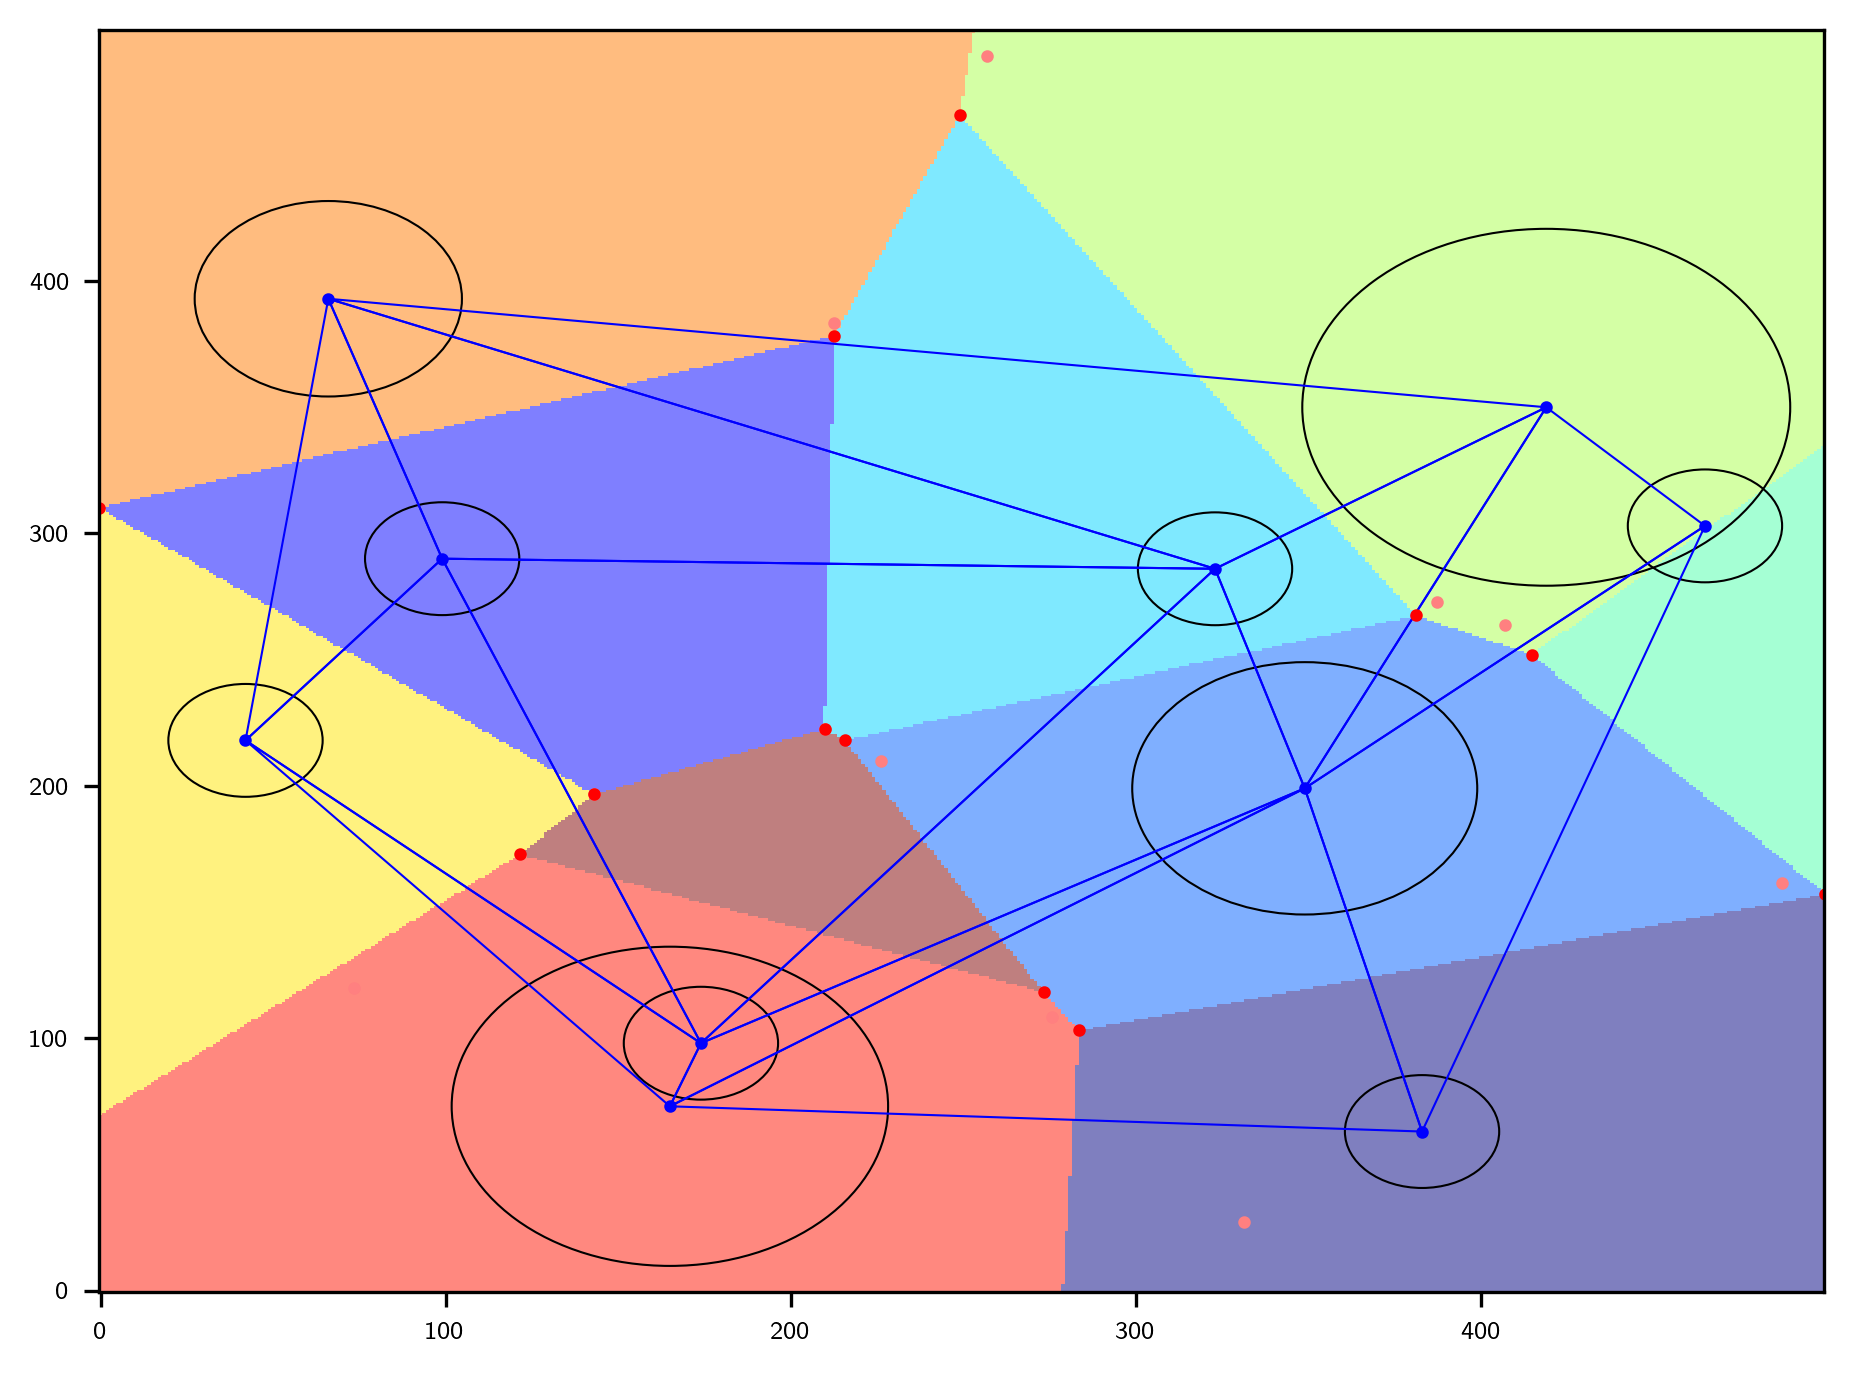

In [126]:
def circumcenter(points):
    """
    Calculates the unweighted circumcenter of the triangle defined by points
    Arguments:
        points: 2D ndarray of triangle vertices with form [[Ax, Ay],[Bx, By],[Cx, Cy]]
    
    Returns:
        circumcenter: [cx, cy] coordinates of the triangle's circumcenter
    """
    
    # Get the permutation needed for Ax(By - Cy), etc
    shifted = np.roll(points, -1, axis=0) - np.roll(points, 1, axis=0)
    flipped = np.fliplr(shifted)
    flipped[:,1] *= -1
    
    # Calculate the magnitude squared of each vertex vector
    mag = np.sum(points**2, axis=1)
    
    # Calculate the circumcenter
    D = 2 * np.sum(points[:,0] * flipped[:,0])
    return (mag @ flipped) / D


# Plot the circumcenter of each Delaunay triangle, including Voronoi cells from the old method to
# check our work

fig, ax = plt.subplots()
grid = voronoi_grid(points_xy, (h, w), weights)
X,Y = np.indices((h,w))
ax.pcolormesh(X,Y, grid, cmap='jet', alpha=.5)
ax.set_ylim(ax.get_ylim())
ax.set_xlim(ax.get_xlim())

# Grab the normal vectors of each face
eqns = (hull.equations[lowers])

for i, s in enumerate(hull.simplices[lowers]):
    # Show the difference between weighted and unweighted circumcenters
    cc = circumcenter(points_xyz[s, :-1])
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    
    # Projecting these back to z=0 gives the Delaunay Triangulation
    ax.plot(points_xyz[s, 0], points_xyz[s, 1],  'b-', lw=0.5)
    
    # Unweighted circumcenters in light red
    ax.plot(cc[0], cc[1], 'o', c = (1,.5,.5))
    
    # Get the weighted circumcenters from the convex hull
    verts = -0.5 * eqns[i, :2] / eqns[i, 2]
    ax.plot(verts[0], verts[1], 'ro')


# Draw the weights of each site
for point, weight in zip(points_xy, weights):
    ax.add_patch(plt.Circle((point[0], point[1]), np.sqrt(weight), color='black', fill=False, lw=0.5))
ax.plot(points_xyz[:, 0], points_xyz[:, 1], 'bo')




print(f'Number of equations: {eqns.shape[0]}')

plt.show()

#### What about the edges?

Right now we have several Voronoi cells with vertices that are infinite. Our calculation doesn't care about the size of our original box, and so several of the circumcenters will be outside of the box or not fully defined by the dual of the Delaunay triangulation. We can fix this by reflecting our sites along each edge of the box and calculating the diagram based on all of those reflected points as well, so the boundary of the box is implicitly taken into account.

In the next plot you can see the vertices of the Voronoi diagram along the edges of the original bounding box.

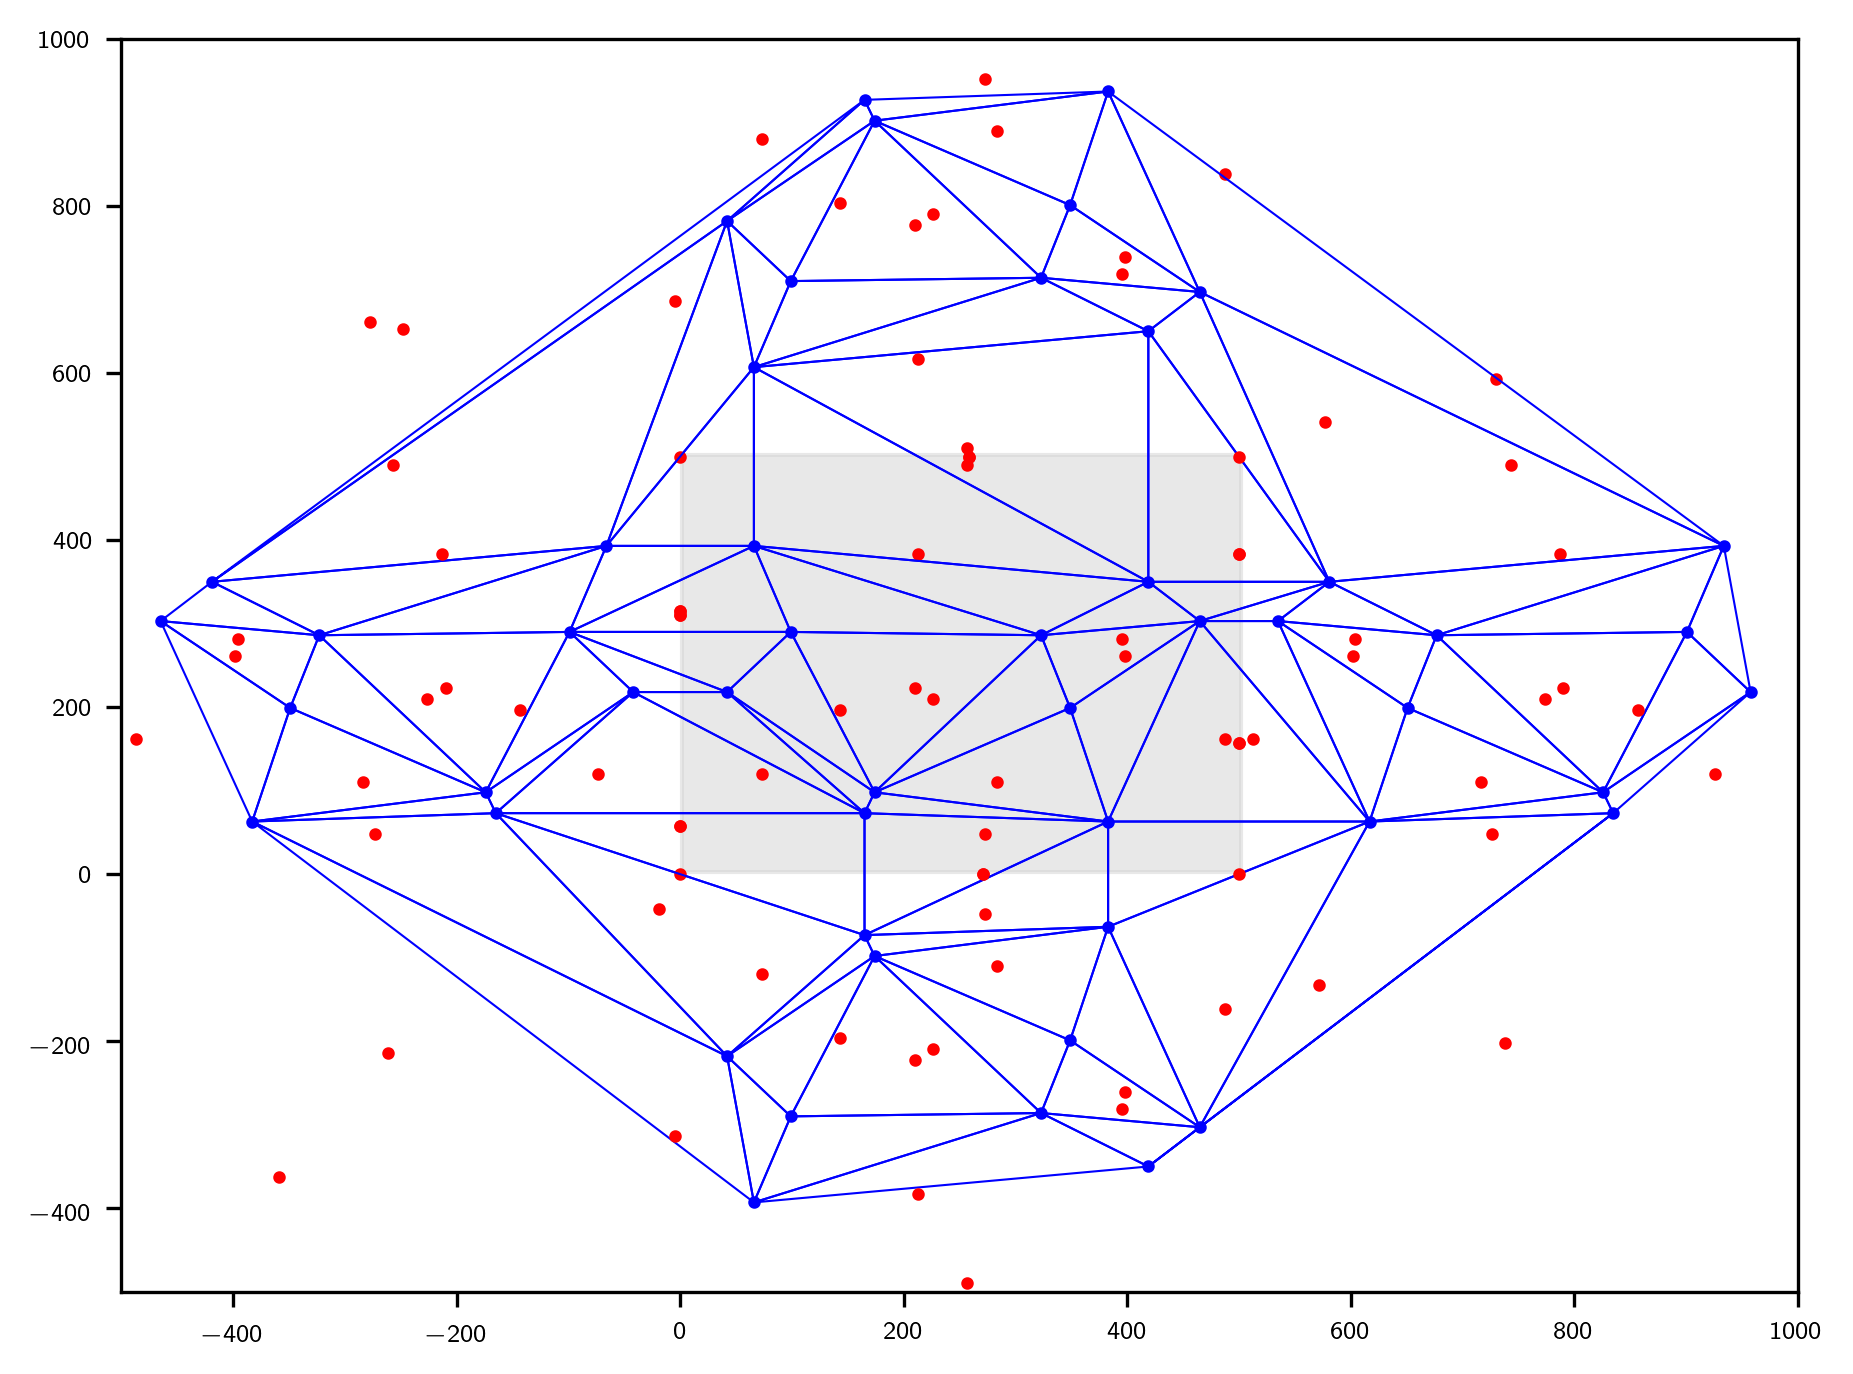

In [127]:
# First we can reflect our original dataset along the edges of the box
pts = points_xy
pts = np.tile(pts, (5,1,1))

pts[[1,2],:,1] *= -1
pts[[3,4],:,0] *= -1

pts[2,:,1] += 2*h
pts[4,:,0] += 2*w

mirrored = pts.reshape((5 * n ,2))

# Lift onto 3D paraboloid
points_xyz = lift_points(mirrored, np.zeros(n * 5))

# Calculate 3D convex hull
mhull = ConvexHull(points_xyz)
lowers = get_lower_facing(mhull)

# Grab the normal vectors of each face
eqns = (mhull.equations[lowers])

# Plot the circumcenter of each Delaunay triangle, including Voronoi cells from the old method to
# check our work

fig, ax = plt.subplots()

ax.set_ylim((-h,2*h))
ax.set_xlim((-w,2*w))

for i, s in enumerate(mhull.simplices[lowers]):
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    
    # Projecting these back to z=0 gives the Delaunay Triangulation
    ax.plot(points_xyz[s, 0], points_xyz[s, 1],  'b-', lw=0.5)
    
    # Get the weighted circumcenters from the convex hull
    verts = -0.5 * eqns[i, :2] / eqns[i, 2]
    ax.plot(verts[0], verts[1], 'ro')

ax.plot(points_xyz[:, 0], points_xyz[:, 1], 'bo')

# Draw the bounding box of the diagram
ax.add_patch(mpl.patches.Rectangle((2, 2), w, h,color="lightgrey", alpha=0.5))

plt.show()

#### Getting the Voronoi Cells

Now we have all the vertices bounded to our original box, all that's left is to define the Voronoi cells around each site.

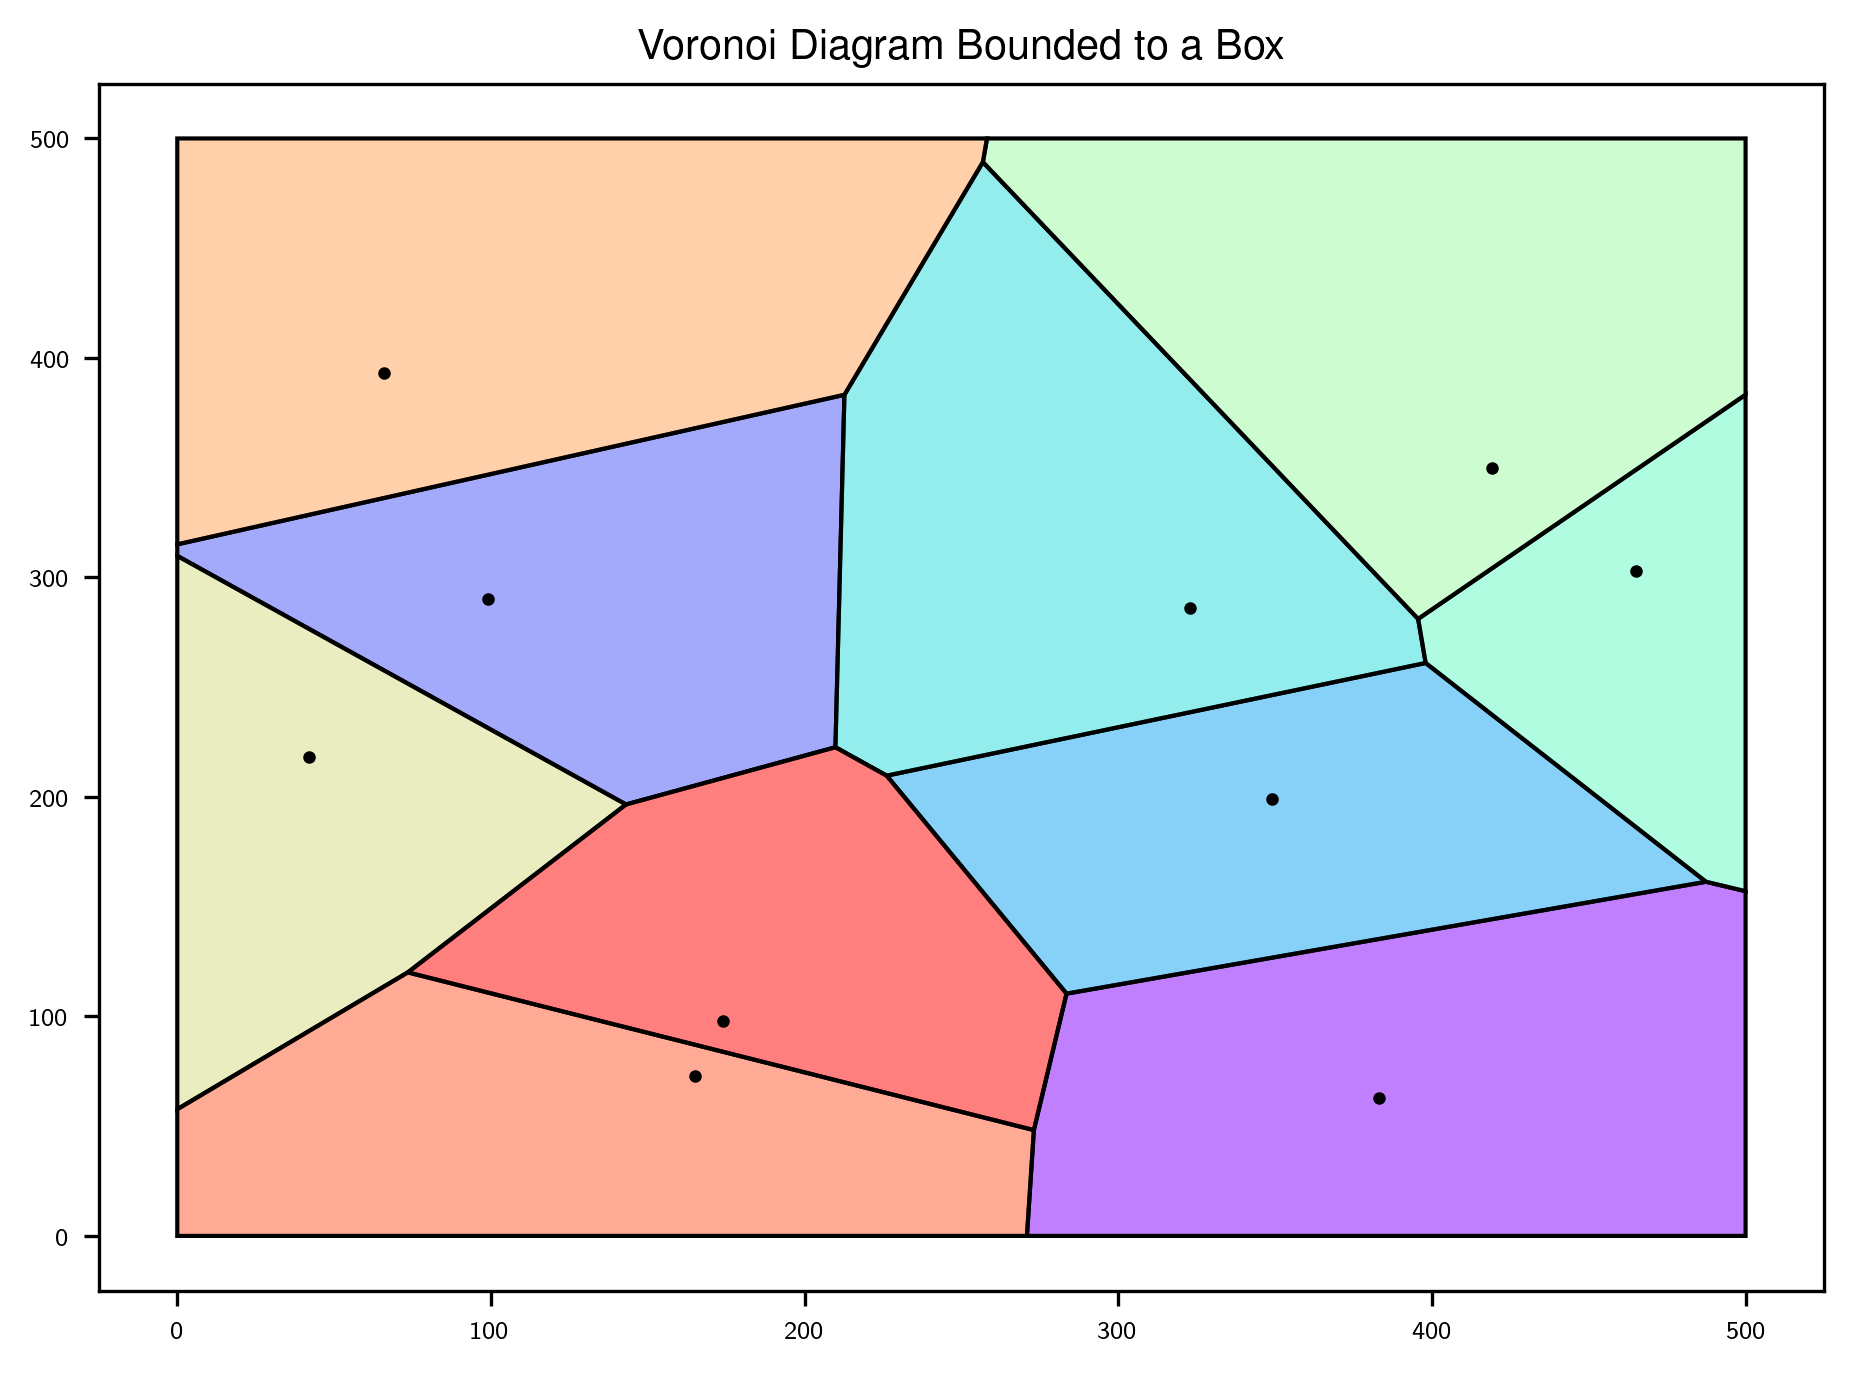

In [131]:
triangles = mhull.simplices[lowers]
eqns = mhull.equations[lowers]

vertices = np.array([-0.5 * eq[:2] / eq[2] for eq in eqns])

fig, ax = plt.subplots()

colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,len(points_xy[:,0])))

for i, site in enumerate(points_xy):

    # for each site, get the weighted circumcenters of all the delaunay triangles it belongs to
    
    # get the indices of all triangles that have point i as a vertex
    indices = np.where(triangles==i)[0]
    #print(f"i = {i}:\n{indices}")
    
    # Get all the vertices from the convex hull
    verts = vertices[indices]
    # Sort the vertices in clockwise order
    verts = np.array(sorted(verts,
                            key = lambda v: np.arctan2((v[1] - site[1]), (v[0] - site[0]))))
   
    ax.fill(verts[:,0], verts[:,1], 
            facecolor=mpl.colors.to_rgba(colors[i],0.5),
            edgecolor='black')

    ax.plot(site[0], site[1], 'ko')
ax.set_title('Voronoi Diagram Bounded to a Box')
plt.show()

### Putting it all together

Now we can package all of these functions into a class for power diagrams. Having the vertices of each region gives us a much faster way to calculate the centroids of each cell, speeding up our Lloyd relaxation.

First let's double check that the weighting is working as intended:


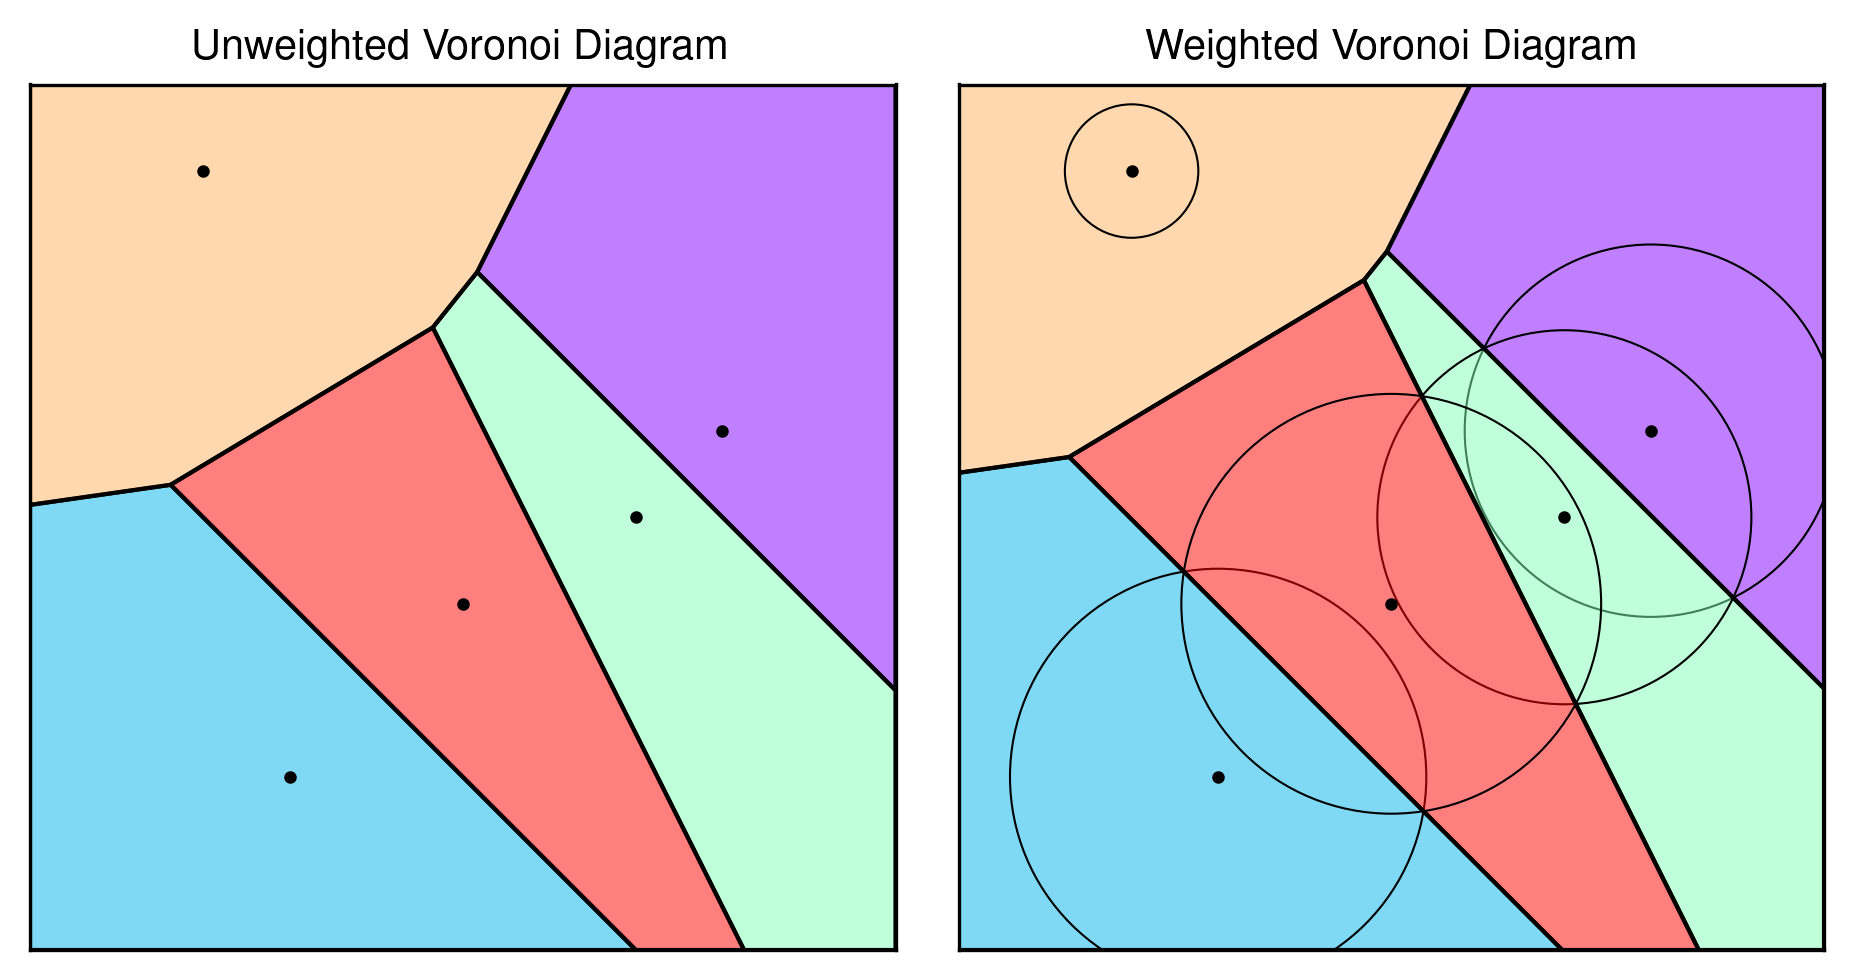

In [134]:
h, w = 10,10
N = 5

X, Y = np.indices((h,w))
weights = np.random.rand(N) * 10

# Randomly pick an index
idx = np.arange(X.size)
rand_idx = np.random.choice(idx, N, replace = False)

# Get the coordinates of each sampled point
pts = np.array([X.flatten()[rand_idx], Y.flatten()[rand_idx]], dtype=float).T

# Calculate the unweighted Voronoi
unweighted = tess.Voronoi(pts, (h, w))
# Calculate the weighted Voronoi
weighted = tess.Voronoi(pts, (h,w), weights)

fig, (ax1, ax2) = plt.subplots(1,2)

unweighted.plot(ax=ax1)
weighted.plot(ax=ax2, plot_weights = True)

# Fix the aspect ratio so circles are still circular
ax1.set_aspect('equal')
ax2.set_aspect('equal')

ax1.set_title('Unweighted Voronoi Diagram')
ax2.set_title('Weighted Voronoi Diagram')
plt.show()

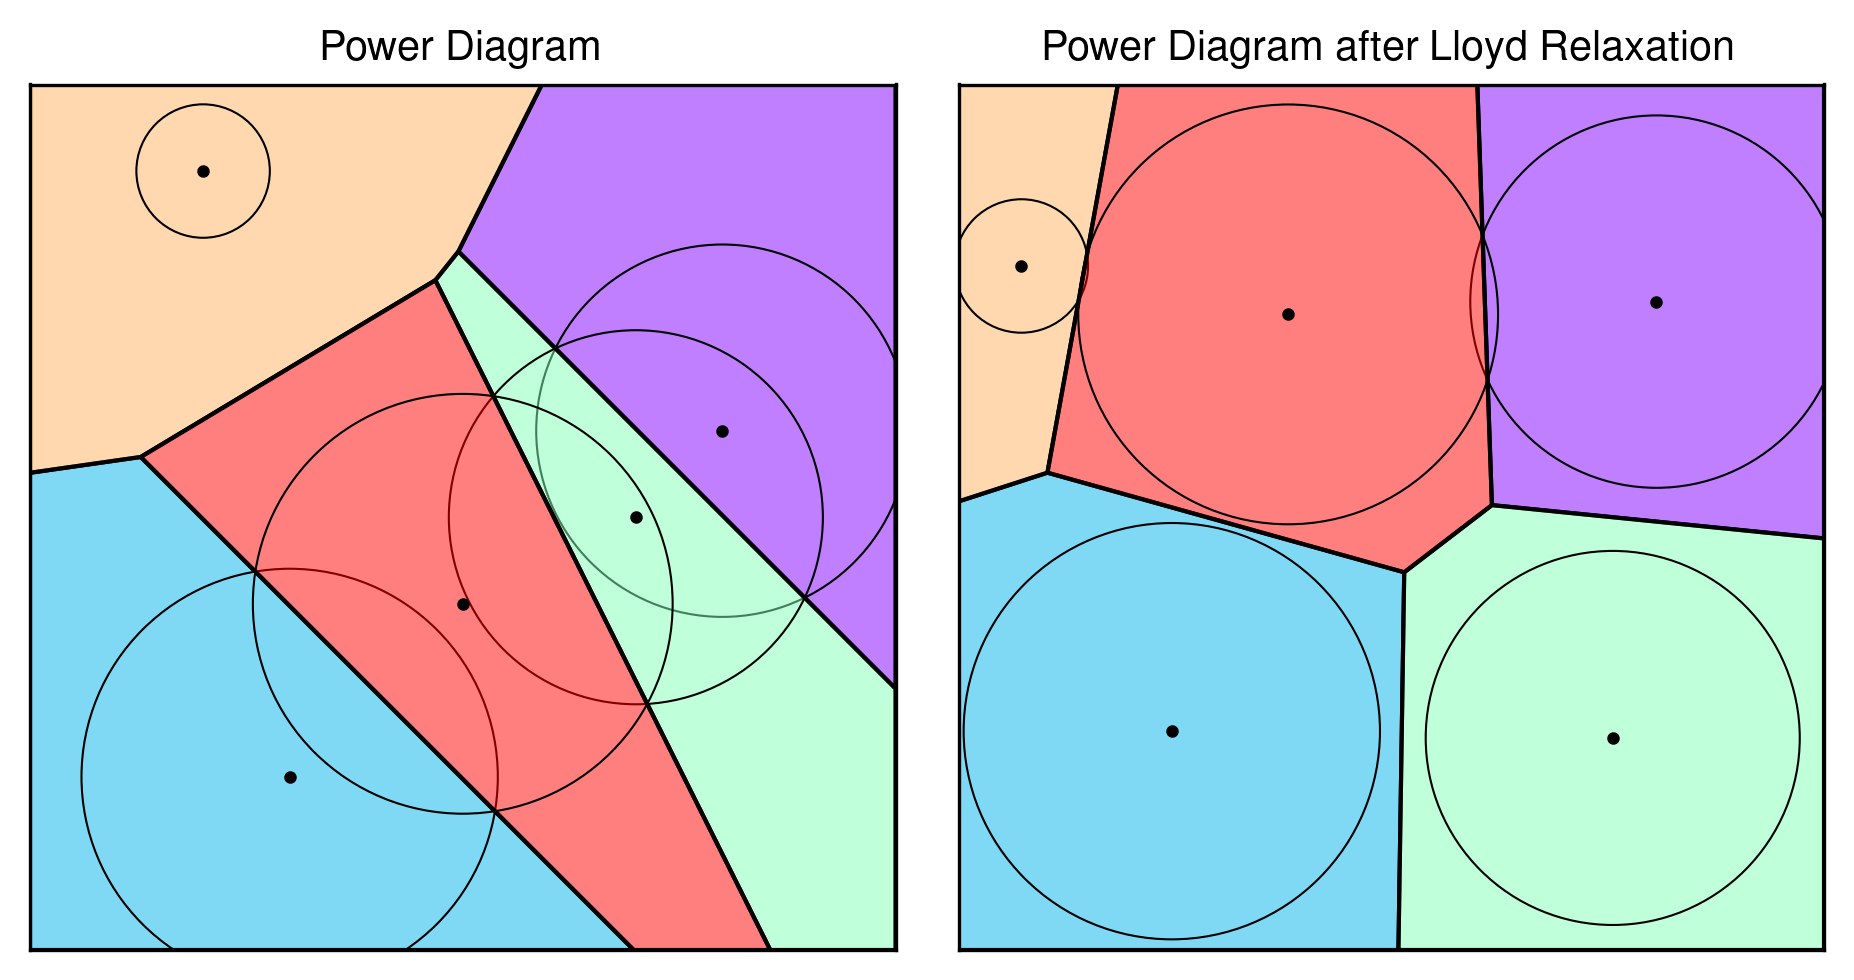

In [141]:
# Test out Lloyd relaxation

vor = tess.Voronoi(pts, (h, w), weights)
relaxed = tess.lloyd(vor)

fig, (ax1, ax2) = plt.subplots(1,2)
vor.plot(ax=ax1, plot_weights=True)
relaxed.plot(ax=ax2, plot_weights=True)
ax2.set_title("Power Diagram after Lloyd Relaxation")
# Fix the aspect ratio so circles are still circular
ax1.set_aspect('equal')
ax2.set_aspect('equal')
plt.show()

## 2. Importance Sampling

Now that we have these algorithms under our belt, we can start working on calculating deflections in shadowgraphy images.

First thing's first we'll make some simple test images to use while developing this method.

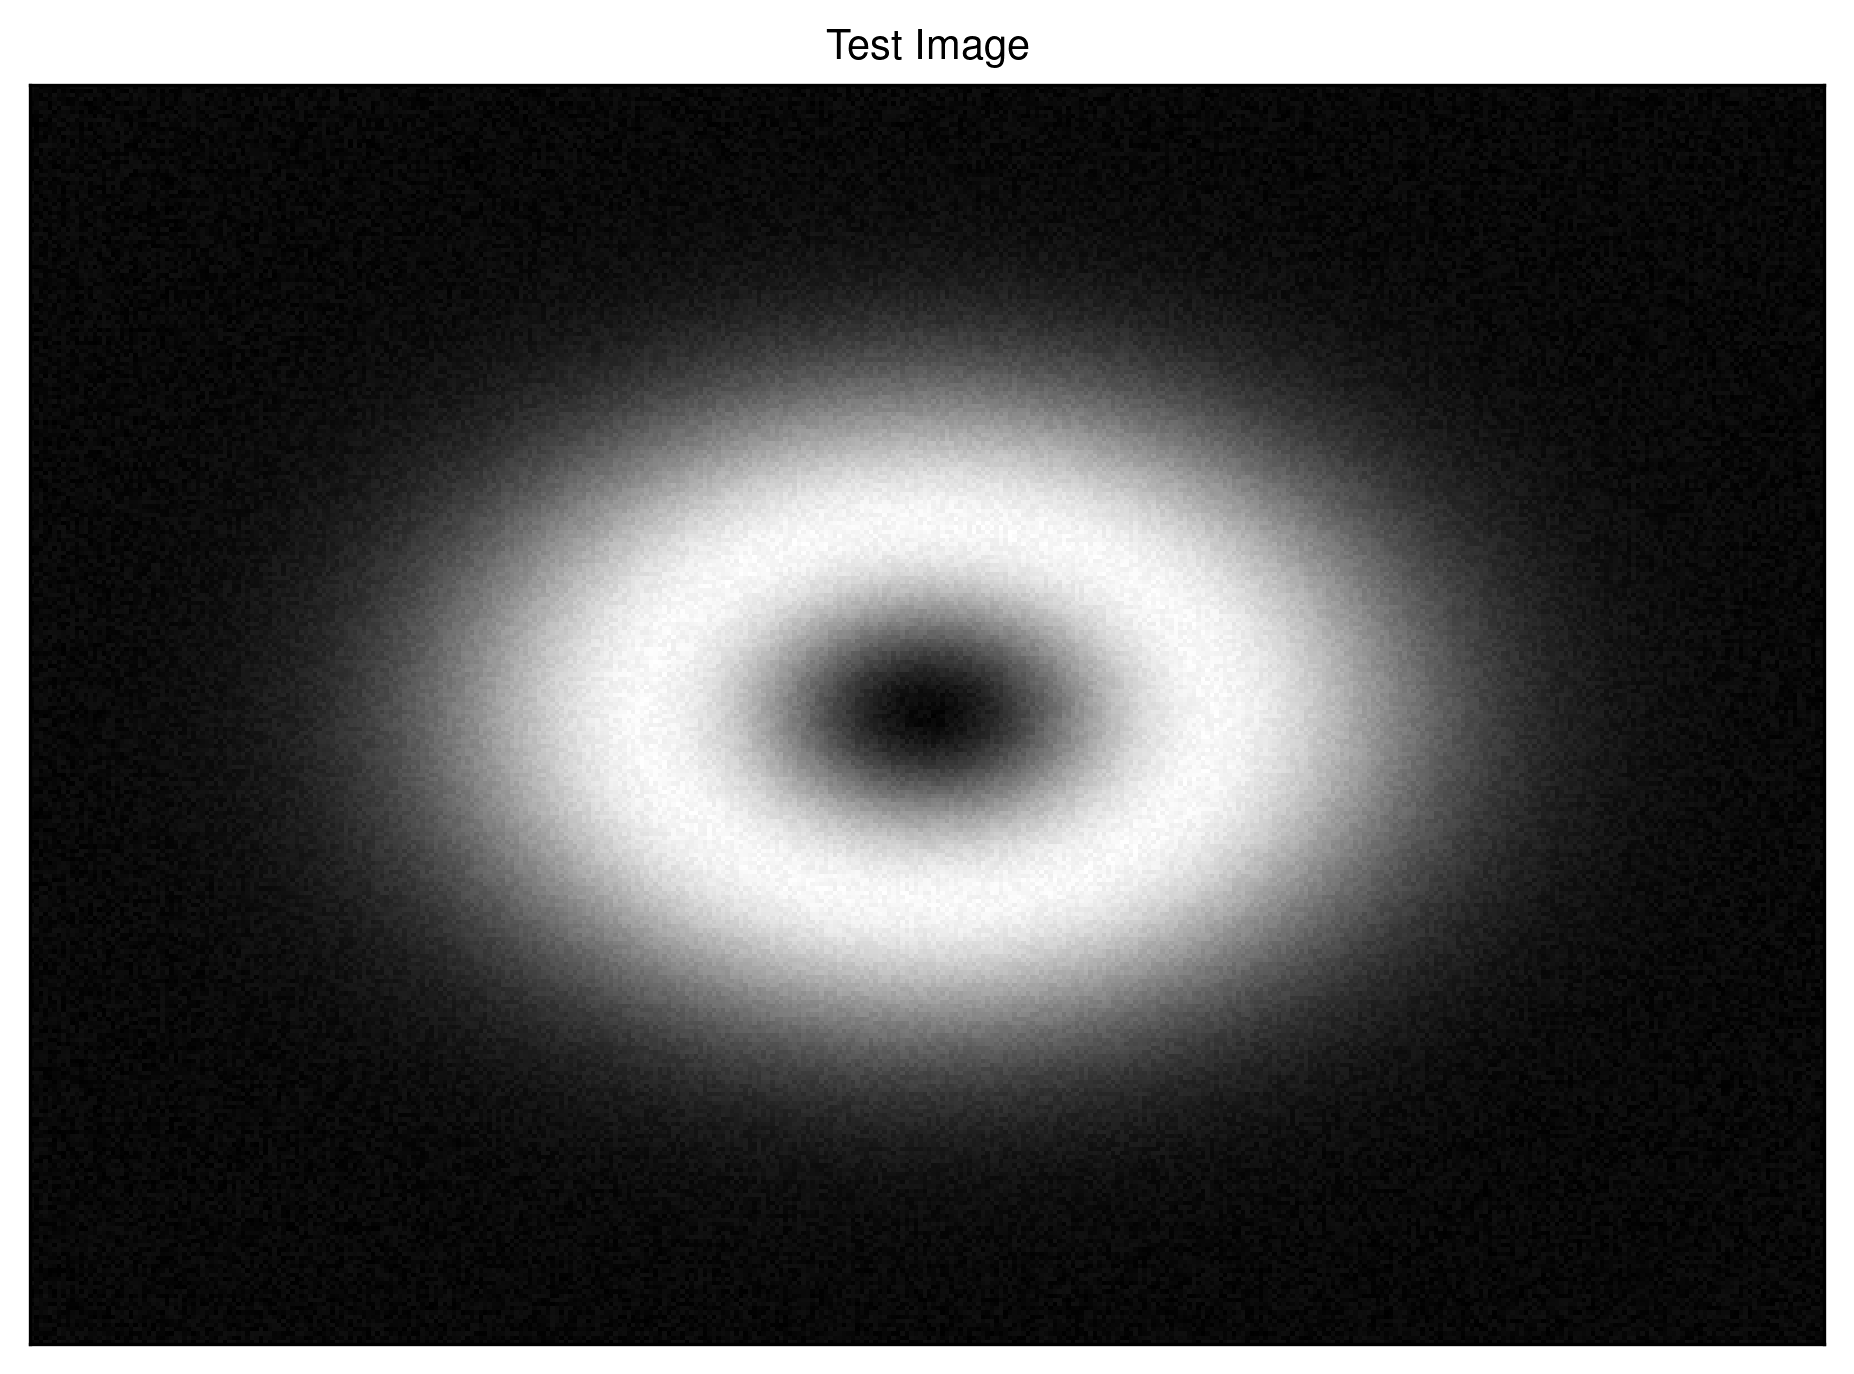

In [142]:
# Generate test data
h, w = 300,400

Y, X = np.indices((h,w))

sig = w/4

test_sig =  -np.exp(-3*(X - w/2)**2/sig**2 - 6* (Y - h/2)**2/sig**2)

test_sig += np.exp(-2*(X - w/2)**2/sig**2 -  4*(Y - h/2)**2/sig**2)

noise = 0.01 * np.random.rand(h,w)
test_sig += noise

fig, ax = plt.subplots()

ax.pcolormesh(X,Y, test_sig, cmap='gray')
ax.tick_params(left=False,
                bottom=False,
                labelleft=False,
                labelbottom=False)
ax.set_title("Test Image")
plt.show()

### Weighted Random Sampling

We could deploy sites entirely randomly on top of this image and continue the analysis from there, but we are trying to keep things speedy, so it's best to start with sites that already look like our signal image.

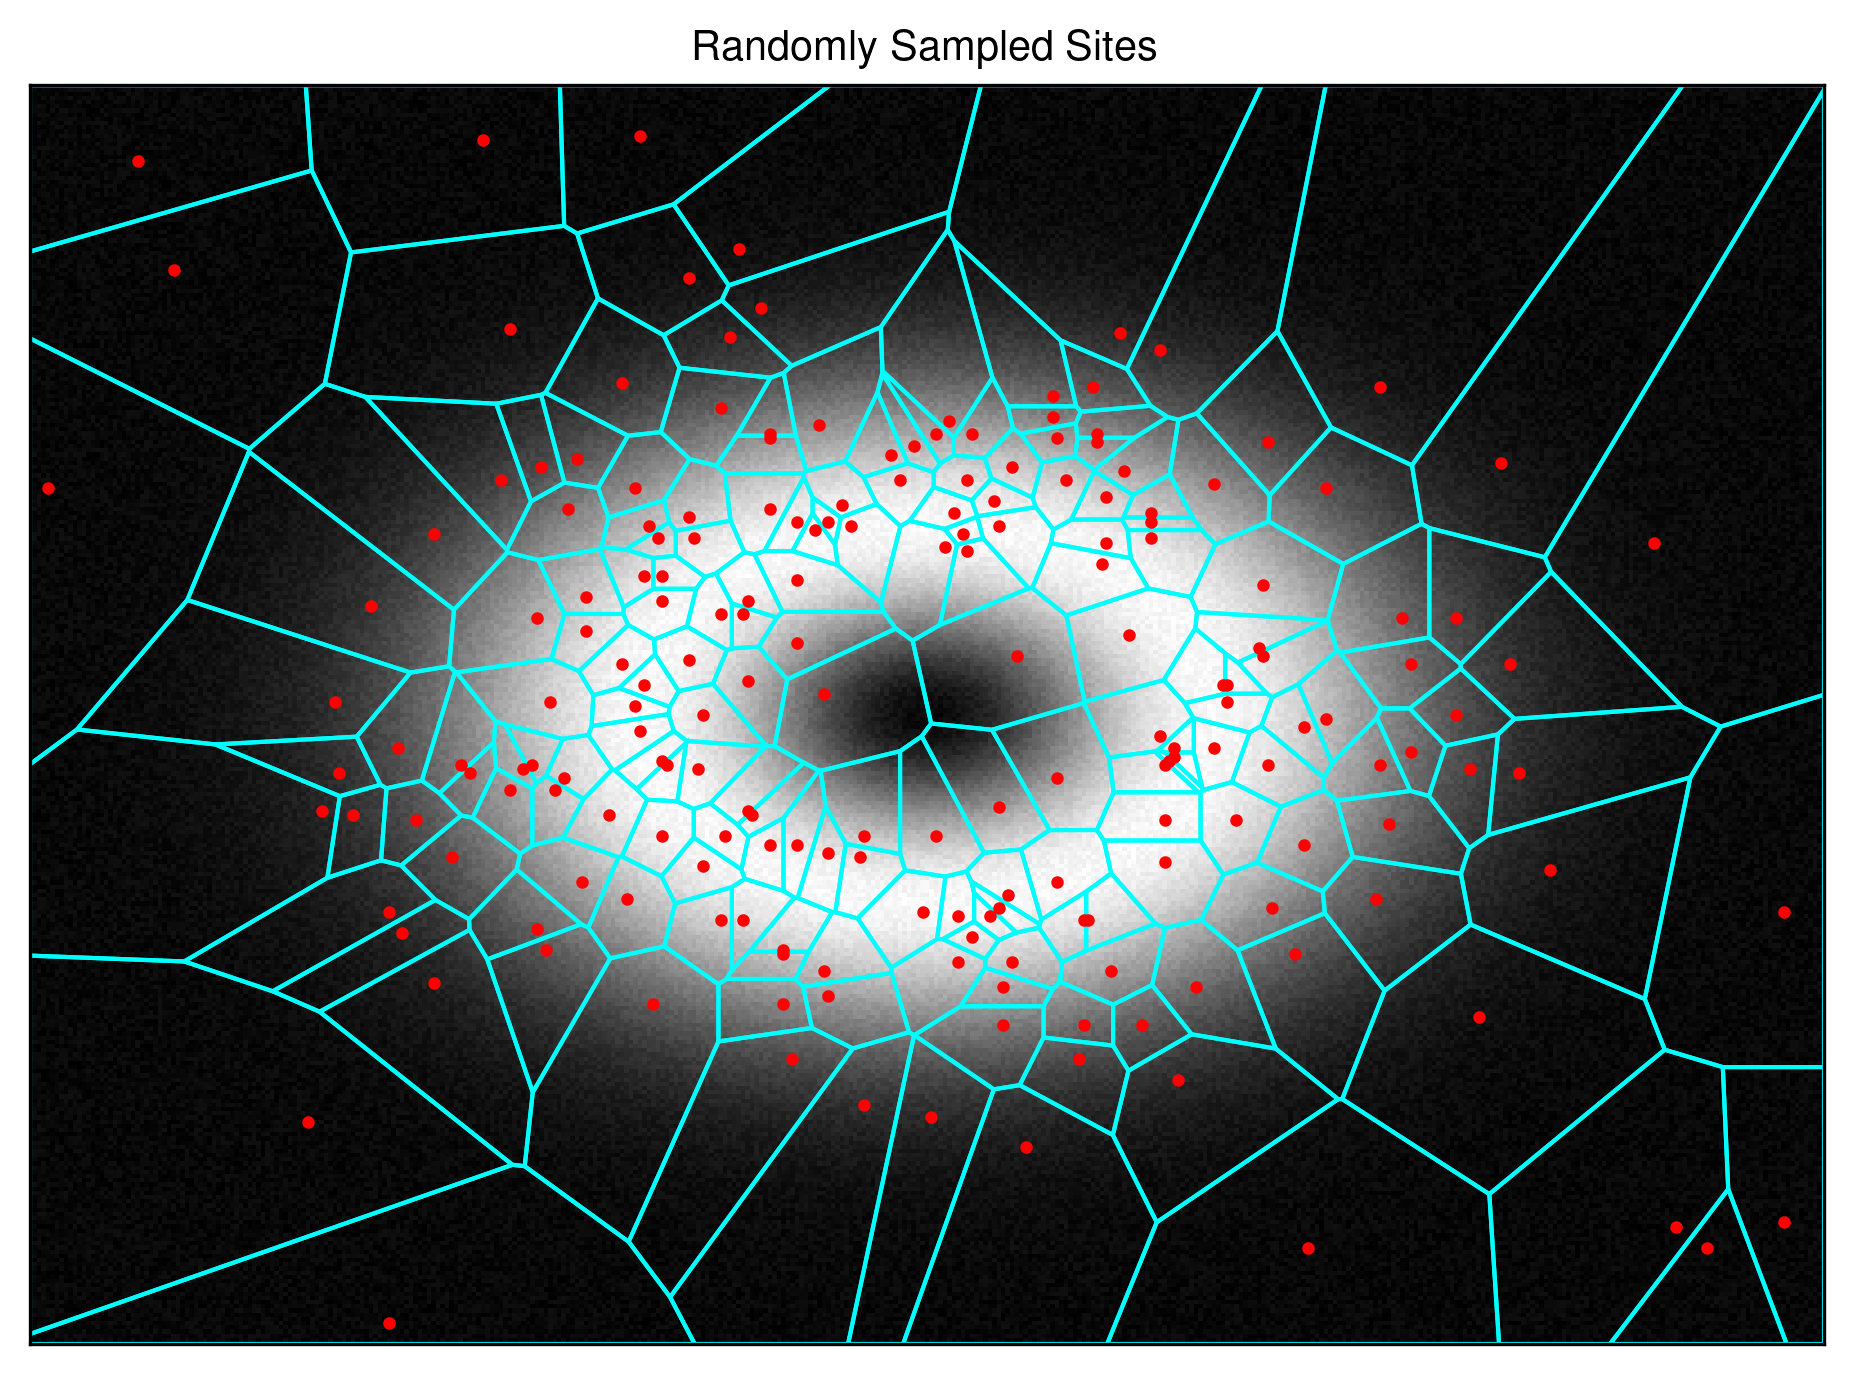

In [147]:
N = 200

# Use the image intensities as the weights for each pixel
weights = test_sig.flatten() / np.sum(test_sig)
# Randomly pick an index
idx = np.arange(len(weights))

rand_idx = np.random.choice(idx, N, replace = False, p = weights)

# Get the coordinates of each sampled point
points = np.array([X.flatten()[rand_idx], Y.flatten()[rand_idx]], dtype=float)
# Get the weights of each site
weights = test_sig.flatten()[rand_idx]


vor = tess.Voronoi(points.T, (h,w), weights)
vor.plot(transparent=True)

ax = plt.gca()

ax.pcolormesh(X,Y, test_sig, cmap='gray')

ax.set_title("Randomly Sampled Sites")
plt.show()

Next we distribute some sites onto this image using Lloyd's algorithm just as before.

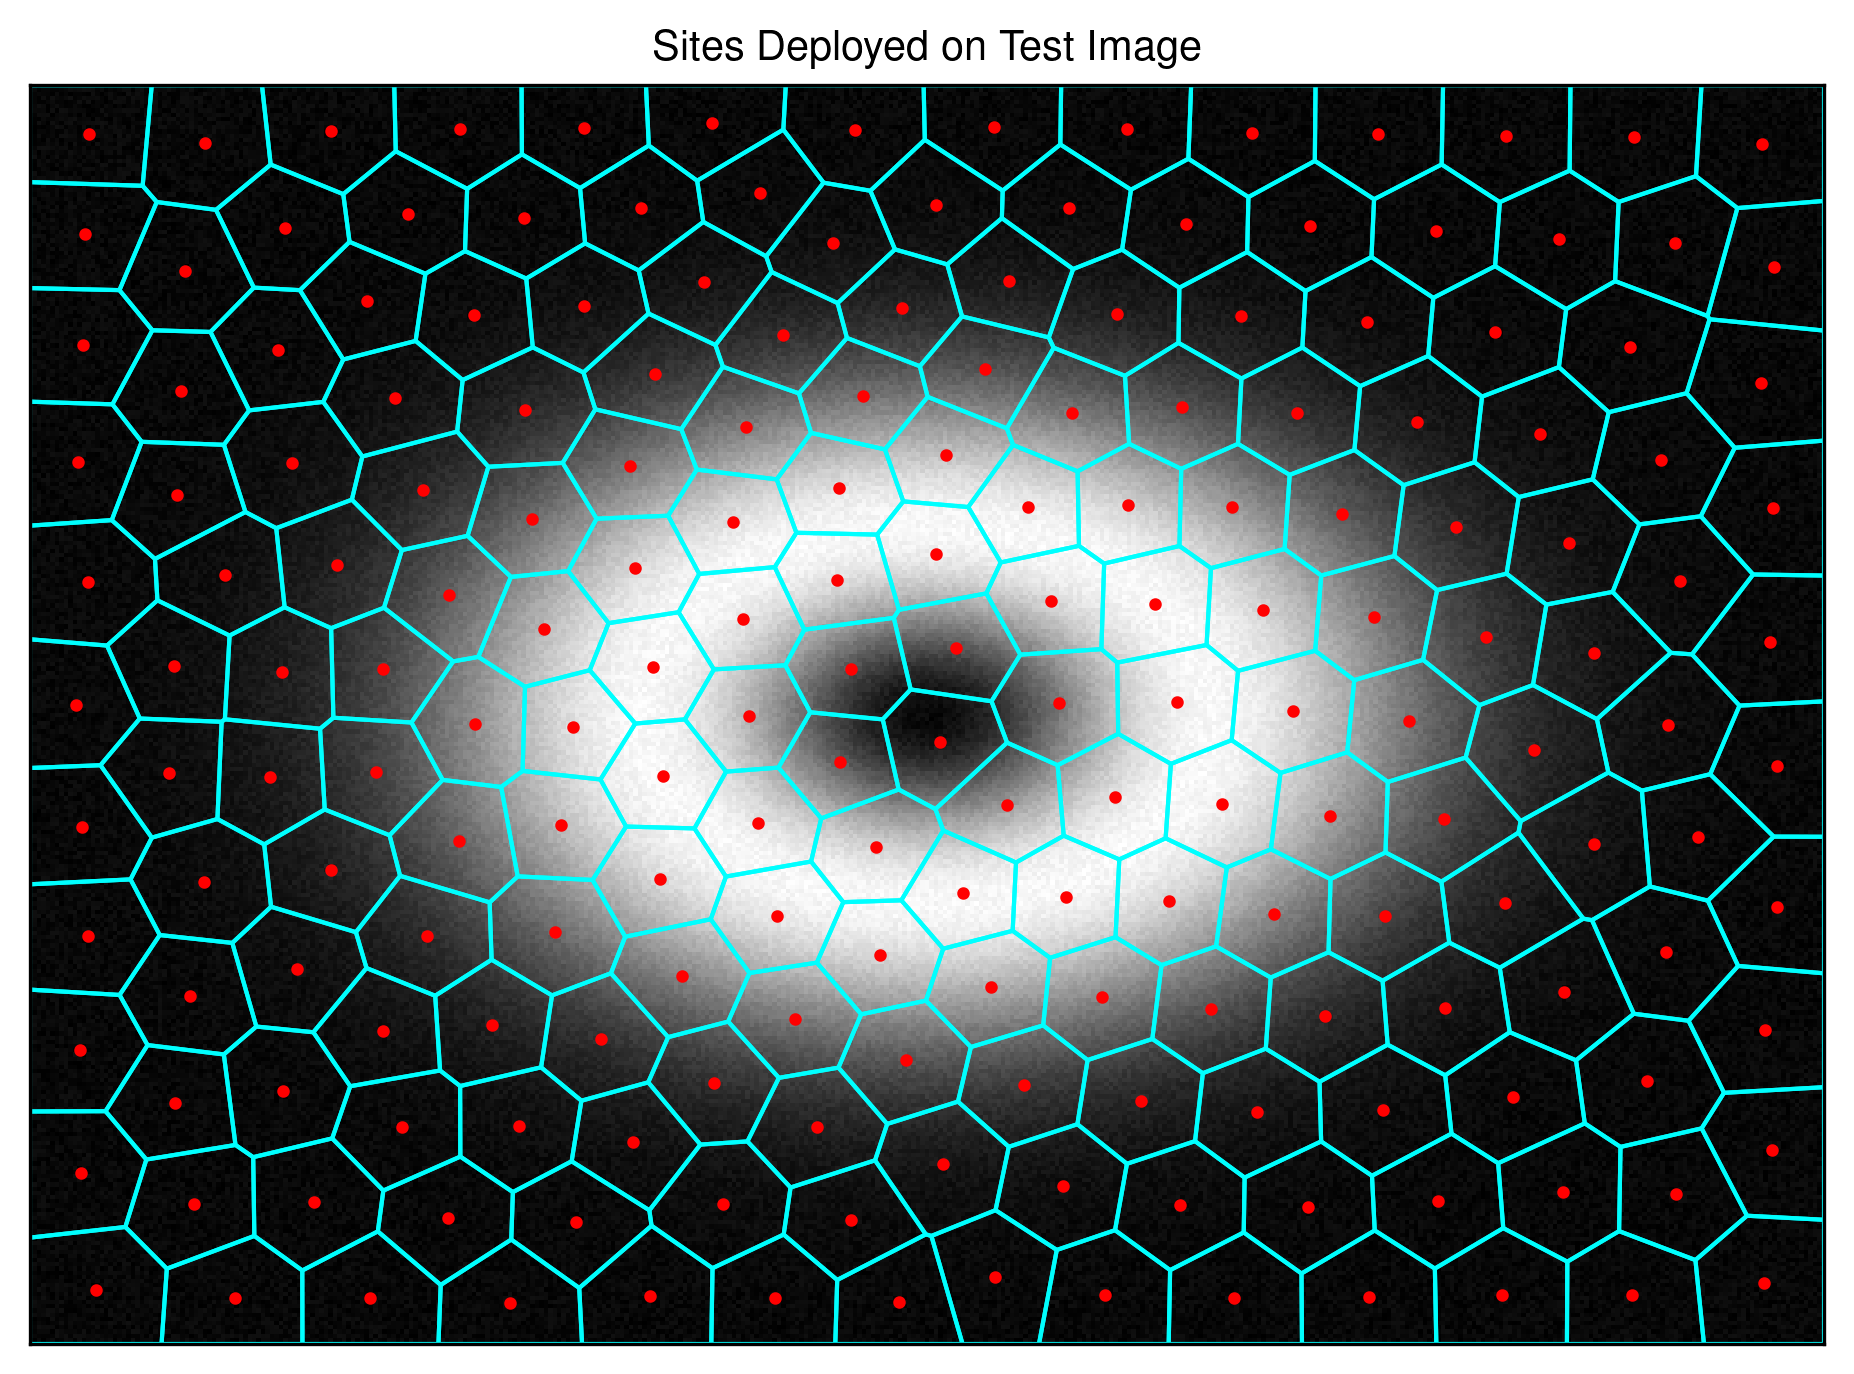

In [149]:
mesh = tess.lloyd(vor)

fig, ax = plt.subplots()

ax.pcolormesh(X,Y, test_sig, cmap='gray')
colors = mpl.cm.get_cmap(name='rainbow')(np.linspace(0,1,N))
ax.set_xlim((0,w))
ax.set_ylim((0,h))

mesh.plot(ax=ax, transparent=True)

ax.set_title("Sites Deployed on Test Image")
plt.show()